# FINAL PROJECT INTRO TO DATA SCIENCE 2023

By: Ofir Salomon and Itzik Ben Harush

In [1]:
import asyncio
from aiohttp import ClientSession
import itertools
from parsel import Selector
import json
import re
import csv
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import requests
from bs4 import BeautifulSoup
from urllib.parse import urlencode
from httpx import AsyncClient
import nest_asyncio
from urllib.parse import urlencode
from typing import List
nest_asyncio.apply()


# SCRAPING:

In this section, we focus on the process of web scraping to gather valuable data from the popular website Booking.com. Our goal is to collect comprehensive information about hotels, including reviews and ratings, from all around the world. Booking.com has been a trusted platform for many years, making it an ideal source for our data extraction.

To accomplish this, we utilize various techniques and tools to automate the scraping process. The main steps involved are as follows:

User-Agent and Headers: We start by setting up the necessary headers and User-Agent to mimic a web browser and prevent our requests from being blocked or identified as bot activity.

Search Page Scraping: We begin by scraping a single hotel search page on Booking.com. We construct the URL with specific parameters, such as the search query, check-in and check-out dates, number of rooms, and offset. These parameters allow us to navigate through the search results and retrieve multiple pages of hotel previews.

Parsing Hotel Previews: Once we retrieve the HTML response of a search page, we parse it using a selector library to extract relevant data. In this case, we focus on extracting the hotel URLs from the search results. We store these URLs in a dictionary for further processing.

Total Search Results: To determine the total number of search results, we parse the HTML response of the first search page. This provides us with an estimate of the total number of hotels available for the given search query.

Scraping Multiple Search Pages: We then proceed to scrape multiple search pages, iterating through the search results by incrementing the offset parameter. This allows us to gather a larger volume of hotel previews, ensuring a more comprehensive dataset.

Proxy Rotation: To enhance our scraping capabilities and avoid being blocked by the website, we implement a proxy rotation mechanism. We maintain a list of proxies and cycle through them for each request, ensuring that our IP address remains anonymous and preventing potential restrictions.

Data Storage: As we collect hotel previews, we store them in a dictionary, mapping the hotel URL to its corresponding entry. We also save the extracted data to a CSV file in real-time, appending new entries as we scrape each search page.

Completion Criteria: We continuously monitor the number of hotel previews collected. Once the desired number of results is reached or the available previews are exhausted, we stop the scraping process

In [ ]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "Connection": "keep-alive",
    "Accept-Language": "en-US,en;q=0.9,lt;q=0.8,et;q=0.7,de;q=0.6",
}

async def search_page(
    query,
    session: ClientSession,
    checkin: str = "",
    checkout: str = "",
    number_of_rooms=1,
    offset: int = 0,
    proxy: str = None,
):
    """Scrapes a single hotel search page of booking.com"""
    checkin_year, checking_month, checking_day = checkin.split("-") if checkin else "", "", ""
    checkout_year, checkout_month, checkout_day = checkout.split("-") if checkout else "", "", ""

    url = "https://www.booking.com/searchresults.html"
    url += "?" + urlencode(
        {
            "ss": query,
            "checkin_year": checkin_year,
            "checkin_month": checking_month,
            "checkin_monthday": checking_day,
            "checkout_year": checkout_year,
            "checkout_month": checkout_month,
            "checkout_monthday": checkout_day,
            "no_rooms": number_of_rooms,
            "offset": offset,
        }
    )

    
    if proxy:
        async with session.get(url, proxy=proxy) as response:
            return await response.text()
    else:
        async with session.get(url) as response:
            return await response.text()


def parse_hotel_preview(html: str):
    """Parses hotel preview data from search page HTML"""
    sel = Selector(text=html)

    hotel_previews = {}
    for hotel_box in sel.xpath('//div[@data-testid="property-card"]'):
        url = hotel_box.xpath('.//h3/a[@data-testid="title-link"]/@href').get("").split("?")[0]
        hotel_previews[url] = url

    return hotel_previews


def parse_search_total_results(html: str):
    """Parses the total number of search results"""
    return 6000  


async def scrape_search(
    query,
    session: ClientSession,
    checkin: str = "",
    checkout: str = "",
    number_of_rooms=1,
    offset: int = 0,
    proxies: List[str] = None,
    max_results: int = 6000,
):
    """Scrapes hotel previews from a given search query"""
    first_page = await search_page(
        query=query, session=session, checkin=checkin, checkout=checkout, number_of_rooms=number_of_rooms, offset=offset
    )
    total_results = parse_search_total_results(first_page)

    tasks = []
    if proxies:
        for curr_offset, proxy in zip(range(offset, total_results, 25), cycle(proxies)):
            tasks.append(
                search_page(
                    query=query,
                    session=session,
                    checkin=checkin,
                    checkout=checkout,
                    number_of_rooms=number_of_rooms,
                    offset=curr_offset,
                    proxy=proxy,
                )
            )
    else:
        tasks = [
            search_page(
                query=query,
                session=session,
                checkin=checkin,
                checkout=checkout,
                number_of_rooms=number_of_rooms,
                offset=curr_offset,
            )
            for curr_offset in range(offset, total_results, 25)
        ]

    hotel_previews = {}
    for response, curr_offset in zip(await asyncio.gather(*tasks), range(offset, total_results, 25)):
        hotel_previews.update(parse_hotel_preview(response))
        if len(hotel_previews) >= max_results:
            break

    return hotel_previews


async def run():
    
    with open('Proxy.txt', 'r') as file:
        proxies = [line.strip() for line in file if line.strip()]

    async with ClientSession(headers=HEADERS) as session:
        complete_data = pd.DataFrame() 
        offset = 0  
        hotel_previews = {} 
        
       
        with open('States.txt', 'r') as file:
            states = [line.strip() for line in file if line.strip()]

        for state in states:
            while len(hotel_previews) < 6000:
                
                proxy = next(cycle(proxies))
                
                
                remaining_results = 6000 - len(hotel_previews)
                
               
                max_results = min(remaining_results, 25)
                
                
                country_results = await scrape_search(
                    query=state,
                    session=session,
                    proxies=[proxy],
                    offset=offset,
                    max_results=max_results,
                )
                
               
                if not country_results:
                    break
                
               
                hotel_previews.update(country_results)
                
                
                df = pd.DataFrame.from_dict(country_results, orient="index", columns=["url"])
                df.to_csv('results.csv', mode='a', header=False, index=False)
                
                
                offset += 25
                
                if len(hotel_previews) >= 6000:
                    print("Desired number of results reached. Stopping the loop.")
                    break
                
                
                complete_data = pd.concat([complete_data, df])
                
        
        complete_data.to_csv('complete_results.csv', index=False)

asyncio.run(run())

In [ ]:

Hotels = []


with open('results.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) 

    
    with open('Proxy.txt', 'r') as proxy_file:
        proxy_list = proxy_file.read().splitlines()

    proxy_cycle = itertools.cycle(proxy_list)  

    for row in csv_reader:
        url = row[0]  

        
        proxy = next(proxy_cycle)
        proxy_dict = {'http': proxy, 'https': proxy}

        try:
            resp = requests.get(url, proxies=proxy_dict)
            soup = BeautifulSoup(resp.text, 'html.parser')

            hotel = {}
            hotel["name"] = soup.find("h2", {"class": "pp-header__title"}).text
            hotel["rating"] = soup.find("div", {"class": "d10a6220b4"}).text

           
            atnm_line = soup.find(text=lambda t: t and "atnm" in t.lower())
            if atnm_line:
                
                match = re.search(r"atnm: '(.*?)'", atnm_line)
                if match:
                    hotel["atnm"] = match.group(1)
                else:
                    hotel["atnm"] = ""
            else:
                hotel["atnm"] = ""
                
           
            region_name_line = soup.find(text=lambda t: t and "region_name" in t.lower())
            if region_name_line:
                
                match = re.search(r"region_name: '(.*?)'", region_name_line)
                if match:
                    hotel["region_name"] = match.group(1)
                else:
                    hotel["region_name"] = ""
            else:
                hotel["region_name"] = ""
                
            
            amenities = [
                "Outdoor swimming pool",
                "Restaurant",
                "Excellent Breakfast",
                "Free parking",
                "Free WiFi",
                "Fitness center",
                "Breakfast",
                "Bar",
                "Very Good Breakfast",
                "Indoor swimming pool",
                "Spa",
                "3 swimming pools",
                "2 swimming pools",
                "4 swimming pools",
                "Room service",
                "Beachfront",
                "Private beach area",
                "WiFi in all areas"
            ]

            for amenity in amenities:
                amenity_text = soup.find(text=amenity)
                hotel[amenity.lower().replace(" ", "_")] = 1 if amenity_text else 0

            Hotels.append(hotel)
        except Exception as e:
            print(f"Error occurred for URL: {url}")
            print(e)


fieldnames = Hotels[0].keys() if Hotels else []
with open('bigdata.csv', 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(Hotels)


In [3]:
df = pd.read_csv('bigdata.csv')
df

,name,rating,atnm,region_name,outdoor_swimming_pool,restaurant,excellent_breakfast,free_parking,free_wifi,fitness_center,...,very_good_breakfast,indoor_swimming_pool,spa,3_swimming_pools,2_swimming_pools,4_swimming_pools,room_service,beachfront,private_beach_area,wifi_in_all_areas
0,Desert Inn,7.6,Motels,New Mexico,0,0,0,0,1,1,...,0,1,1,0,0,0,0,0,0,0
1,Super 8 by Wyndham Portales,6.9,Motels,New Mexico,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Ohkay Hotel Casino,7.9,Hotels,New Mexico,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
3,Best Western Plus Portales Inn,8.6,Hotels,New Mexico,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
4,"Holiday Inn Express & Suites Portales, an IHG ...",8.3,Hotels,New Mexico,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,"Motel 6-Porterville, CA",6.3,Hotels,California,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5929,Wildflower Boutique Motel,9.4,Hotels,California,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5930,WorldMark Clear Lake,9.1,Hotels,California,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5931,Sonesta Select Pleasant Hill,8.0,Hotels,California,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0


# PROCESSING

After receiving the required standings, 
We will examine the quantities of each type and then categorize the necessary records into binary and categorical.

In [4]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5933 entries, 0 to 5932
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   5933 non-null   object 
 1   rating                 5933 non-null   float64
 2   atnm                   5924 non-null   object 
 3   region_name            5933 non-null   object 
 4   outdoor_swimming_pool  5933 non-null   int64  
 5   restaurant             5933 non-null   int64  
 6   excellent_breakfast    5933 non-null   int64  
 7   free_parking           5933 non-null   int64  
 8   free_wifi              5933 non-null   int64  
 9   fitness_center         5933 non-null   int64  
 10  breakfast              5933 non-null   int64  
 11  bar                    5933 non-null   int64  
 12  very_good_breakfast    5933 non-null   int64  
 13  indoor_swimming_pool   5933 non-null   int64  
 14  spa                    5933 non-null   int64  
 15  3_sw

,rating,outdoor_swimming_pool,restaurant,excellent_breakfast,free_parking,free_wifi,fitness_center,breakfast,bar,very_good_breakfast,indoor_swimming_pool,spa,3_swimming_pools,2_swimming_pools,4_swimming_pools,room_service,beachfront,private_beach_area,wifi_in_all_areas
count,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000,5933.000000
mean,8.064858,0.280297,0.183381,0.008427,0.669139,0.934266,0.432665,0.616214,0.189617,0.022586,0.128603,0.585033,0.002528,0.026968,0.001011,0.120007,0.037586,0.009944,0.012978
std,1.200709,0.449182,0.387011,0.091421,0.470563,0.247837,0.495487,0.486348,0.392031,0.148591,0.334788,0.492758,0.050222,0.162003,0.031787,0.324997,0.190210,0.099233,0.113190
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.200000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.800000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Calculate normalized rating using cumulative distribution function (CDF)

In this section, we perform data processing and normalization operations on the DataFrame to prepare the data for analysis. The following steps are carried out:

Converting Data Types: We convert the 'rating' column to a numeric data type. Any values that cannot be converted to numeric are replaced with NaN (Not a Number).

Calculating Mean and Standard Deviation: We calculate the mean and standard deviation of the 'rating' column. These statistical measures provide insights into the central tendency and spread of the 'rating' values within the dataset.

Normalizing the Ratings: To normalize the 'rating' values, we use the cumulative distribution function (CDF) assuming a normal distribution. The CDF calculates the probability that a random variable takes on a value less than or equal to a given value. By applying the CDF function to the 'rating' column, we obtain the normalized ratings, representing the probabilities of each rating value within the dataset.

Displaying the Transformed DataFrame: We print the transformed DataFrame to observe the changes made during the data processing and normalization steps. This allows us to visually inspect the updated dataset, including the converted 'rating' column, calculated normalized ratings, and other existing columns.

In [5]:
df.loc[:, 'rating'] = pd.to_numeric(df['rating'], errors='coerce')
mean_rating = df['rating'].mean()
std_rating = df['rating'].std()
df.loc[:, 'rating_normalized'] = stats.norm.cdf(df['rating'], mean_rating, std_rating)
print(df)

                                                   name  rating    atnm   
0                                            Desert Inn     7.6  Motels  \
1                           Super 8 by Wyndham Portales     6.9  Motels   
2                                    Ohkay Hotel Casino     7.9  Hotels   
3                        Best Western Plus Portales Inn     8.6  Hotels   
4     Holiday Inn Express & Suites Portales, an IHG ...     8.3  Hotels   
...                                                 ...     ...     ...   
5928                            Motel 6-Porterville, CA     6.3  Hotels   
5929                          Wildflower Boutique Motel     9.4  Hotels   
5930                               WorldMark Clear Lake     9.1  Hotels   
5931                       Sonesta Select Pleasant Hill     8.0  Hotels   
5932                               Vineyard Country Inn     8.8    Inns   

     region_name  outdoor_swimming_pool  restaurant  excellent_breakfast   
0     New Mexico       

# Here you can see the distribution of ratings 

we visualize the distribution of ratings in the DataFrame using a bar plot. The following steps are executed:

Setting the Figure Size: We set the size of the figure using plt.figure(figsize=(25, 15)) to ensure that the plot has appropriate dimensions and is easily readable.

Creating the Count Plot: We create a count plot using sns.countplot() from the Seaborn library. The count plot allows us to visualize the frequency of each rating value in the 'rating' column.

Specifying the Data and x-Axis: We specify the DataFrame (data=df) from which the data will be plotted and the variable to be displayed on the x-axis (x='rating').

Displaying the Plot: We use plt.show() to display the bar plot visualization on the screen.

By generating this rating distribution plot, we gain insights into the distribution of ratings within the dataset. The count plot provides a visual representation of the frequency of each rating value, allowing us to observe any patterns or imbalances in the rating distribution.

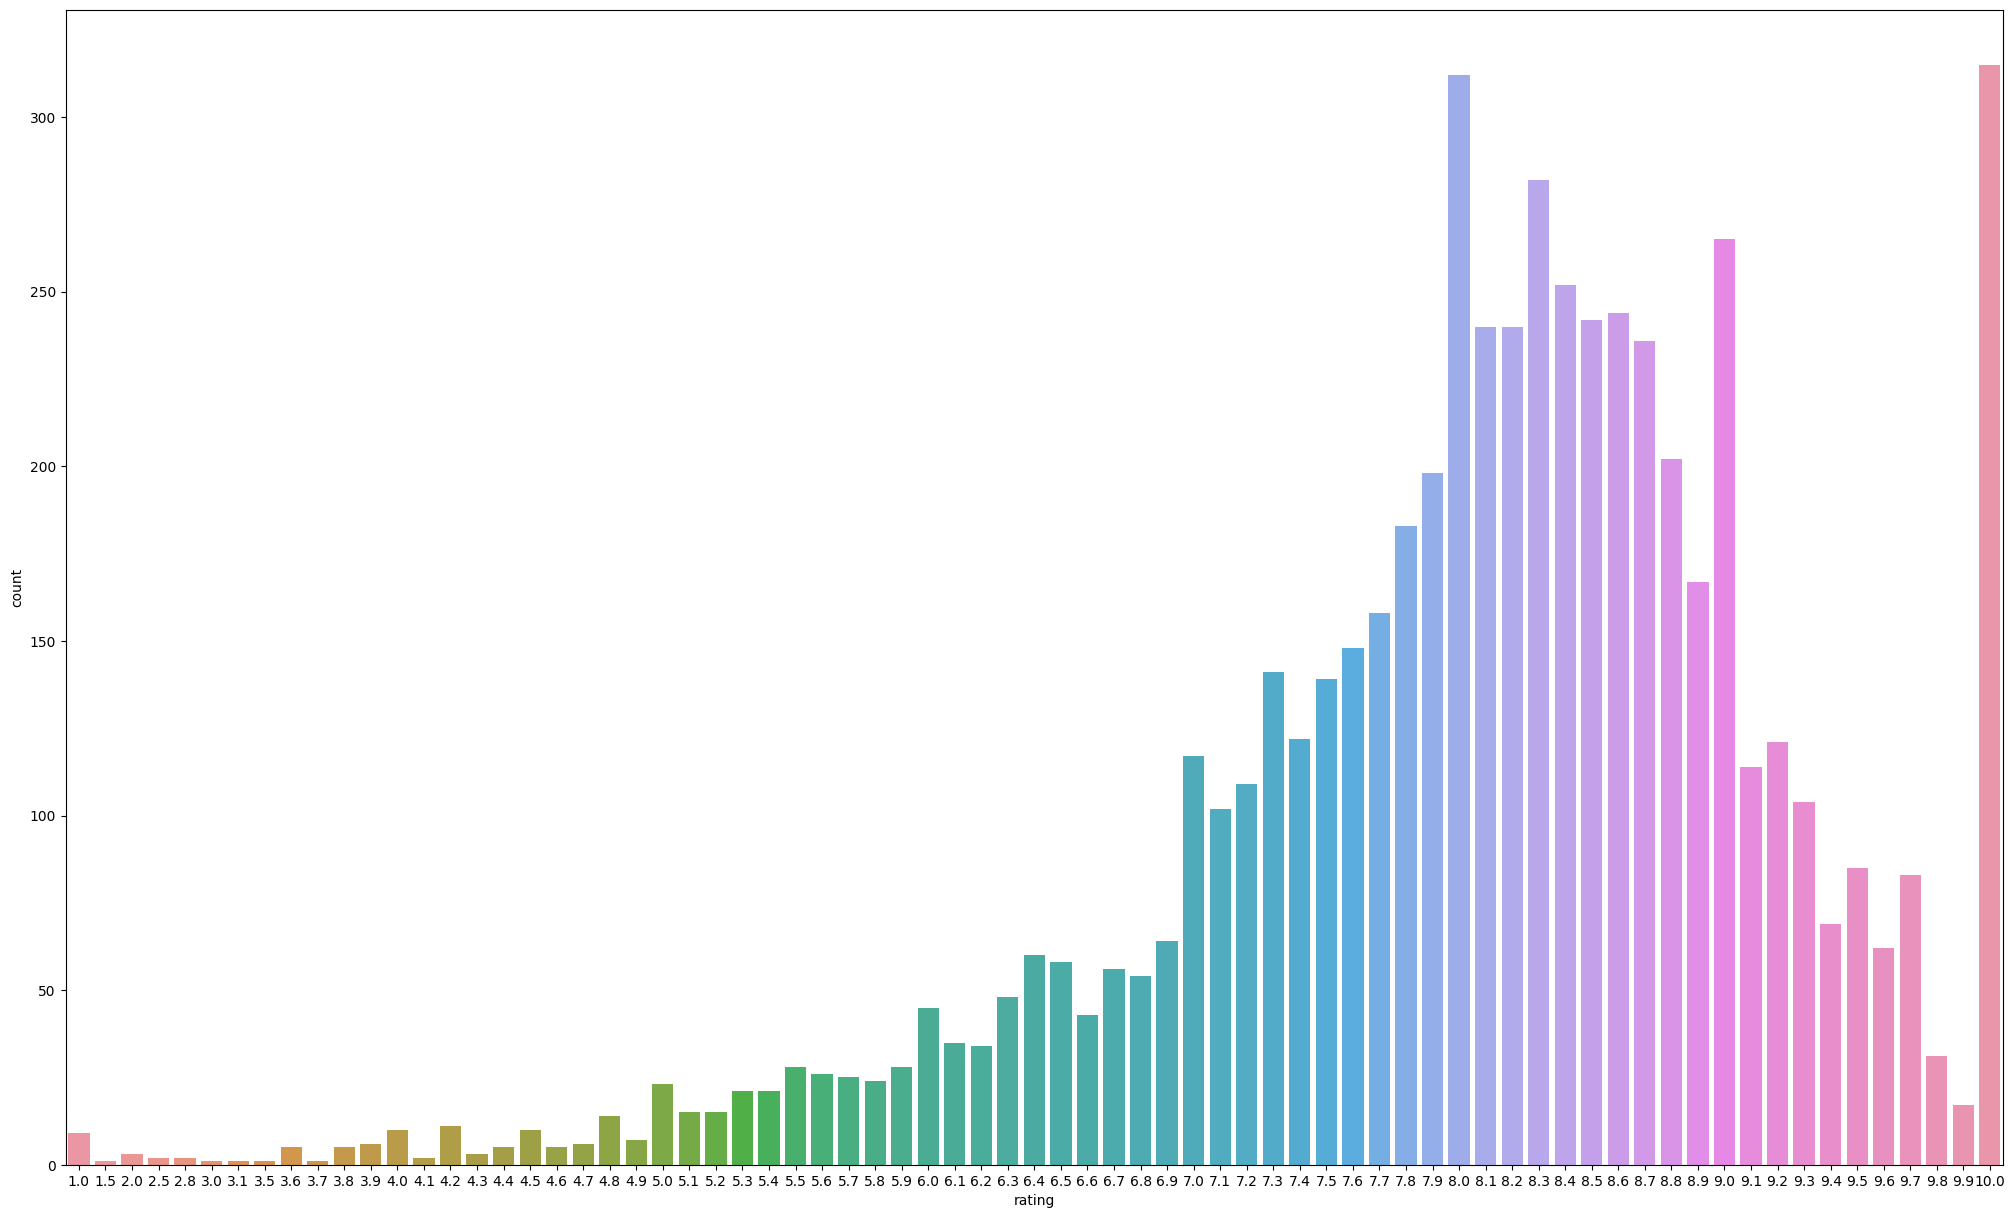

In [6]:
plt.figure(figsize=(25, 15)) 
sns.countplot(data=df, x='rating')
plt.show()


# Data Cleaning Section:

we visualize the binary columns in the DataFrame and handle missing values. The following steps are performed:

Checking for Missing Values: We use df.isnull().sum() to determine the number of missing values in each column of the DataFrame. This helps us identify any columns that contain missing data.

Dropping Rows with Missing Values: We drop rows that contain missing values using df = df.dropna(). This ensures that we have a clean dataset without any missing data, which is essential for accurate analysis and visualization.

Defining Binary Columns: We define a list called binary_cols that contains the names of the binary columns in the DataFrame. These columns represent features that have a binary value of either 0 or 1.

Creating Subplots: We create subplots using plt.subplots() to display individual bar plots for each binary column. The subplots are arranged in a vertical layout, with the number of subplots determined by the length of binary_cols.

Plotting Bar Plots: For each binary column, we iterate over binary_cols and create a bar plot using ax.bar(). The bar plot represents the count of 1's and 0's in the respective column.

Customizing Axes: We customize each subplot by setting the x-axis label, y-axis label, and title using ax.set_xlabel(), ax.set_ylabel(), and ax.set_title() respectively. We also set the x-axis ticks to display only 0 and 1 using ax.set_xticks().

Ensuring Layout and Display: We use plt.tight_layout() to optimize the spacing between subplots and ensure they are clearly visible. Finally, we use plt.show() to display the subplots on the screen.

By visualizing the binary columns in this manner, we gain insights into the distribution and imbalance of binary features within the dataset. Additionally, by dropping rows with missing values, we ensure the integrity of the data for subsequent analysis and modeling tasks.

In [7]:
df.isnull().sum()  
df = df.dropna()  

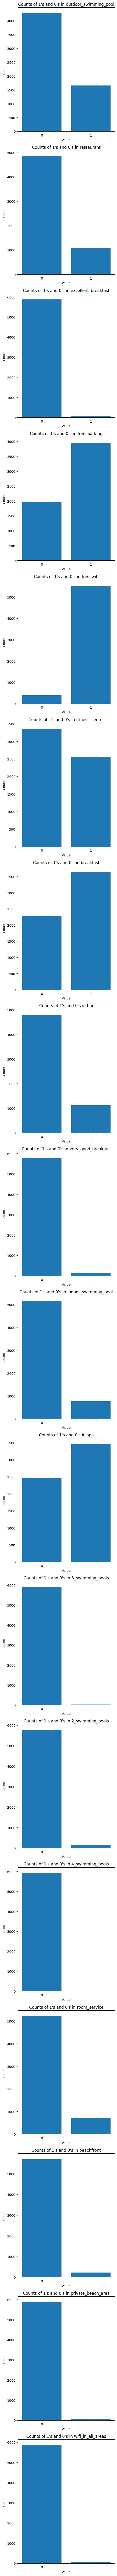

In [8]:
import matplotlib.pyplot as plt

binary_cols = ['outdoor_swimming_pool', 'restaurant', 'excellent_breakfast', 'free_parking', 'free_wifi',
               'fitness_center', 'breakfast', 'bar', 'very_good_breakfast', 'indoor_swimming_pool',
               'spa', '3_swimming_pools', '2_swimming_pools', '4_swimming_pools', 'room_service',
               'beachfront', 'private_beach_area', 'wifi_in_all_areas']

fig, axes = plt.subplots(len(binary_cols), 1, figsize=(5, len(binary_cols) * 6))

for i, col in enumerate(binary_cols):
    ax = axes[i]
    value_counts = df[col].value_counts()
    ax.bar(value_counts.index, value_counts.values)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f"Counts of 1's and 0's in {col}")
    ax.set_xticks([0, 1])

plt.tight_layout()
plt.show()


# Deleting irrelevant columns.

In [9]:
del df['excellent_breakfast']
del df['free_wifi']
del df['very_good_breakfast']
del df['3_swimming_pools']
del df['2_swimming_pools']
del df['4_swimming_pools']
del df['beachfront']
del df['private_beach_area']
del df['wifi_in_all_areas']

In [10]:
df

,name,rating,atnm,region_name,outdoor_swimming_pool,restaurant,free_parking,fitness_center,breakfast,bar,indoor_swimming_pool,spa,room_service,rating_normalized
0,Desert Inn,7.6,Motels,New Mexico,0,0,0,1,1,0,1,1,0,0.349322
1,Super 8 by Wyndham Portales,6.9,Motels,New Mexico,0,0,1,0,1,0,0,0,0,0.165988
2,Ohkay Hotel Casino,7.9,Hotels,New Mexico,1,1,1,1,1,1,0,1,0,0.445397
3,Best Western Plus Portales Inn,8.6,Hotels,New Mexico,0,0,1,1,1,0,0,1,0,0.672089
4,"Holiday Inn Express & Suites Portales, an IHG ...",8.3,Hotels,New Mexico,0,0,0,1,1,0,0,1,0,0.577631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,"Motel 6-Porterville, CA",6.3,Hotels,California,1,0,1,0,0,0,0,0,0,0.070802
5929,Wildflower Boutique Motel,9.4,Hotels,California,0,0,1,0,1,0,0,0,0,0.866923
5930,WorldMark Clear Lake,9.1,Hotels,California,0,0,1,0,0,0,0,0,0,0.805686
5931,Sonesta Select Pleasant Hill,8.0,Hotels,California,0,1,0,1,1,0,0,1,0,0.478461


In [11]:

hotel_counts = df['atnm'].value_counts()

print(hotel_counts)

atnm
Hotels                3462
Vacation Homes         802
Motels                 580
Apartments             364
Resorts                147
Inns                   137
Bed and Breakfasts     128
Lodges                 108
Condo Hotels            66
Guesthouses             33
Homestays               24
Hostels                 22
Villas                  14
Campgrounds             13
Luxury tents             9
Resort Villages          7
Country Houses           4
Farm Stays               3
Capsule Hotels           1
Name: count, dtype: int64


In [12]:

types_to_delete = ['Capsule Hotels', 'Farm Stays', 'Country Houses', 'Resort Villages', 'Campgrounds', 'Luxury tents']
df = df[~df['atnm'].isin(types_to_delete)]

print(df)

                                                   name  rating    atnm   
0                                            Desert Inn     7.6  Motels  \
1                           Super 8 by Wyndham Portales     6.9  Motels   
2                                    Ohkay Hotel Casino     7.9  Hotels   
3                        Best Western Plus Portales Inn     8.6  Hotels   
4     Holiday Inn Express & Suites Portales, an IHG ...     8.3  Hotels   
...                                                 ...     ...     ...   
5928                            Motel 6-Porterville, CA     6.3  Hotels   
5929                          Wildflower Boutique Motel     9.4  Hotels   
5930                               WorldMark Clear Lake     9.1  Hotels   
5931                       Sonesta Select Pleasant Hill     8.0  Hotels   
5932                               Vineyard Country Inn     8.8    Inns   

     region_name  outdoor_swimming_pool  restaurant  free_parking   
0     New Mexico              

# EDA & Visualization

Now where missing values, outliers, and inconsistencies are addressed. This ensures the data is reliable and ready for analysis.
considered here among others

Statistics such as mean, median, standard deviation, and quartiles to understand the central tendency and dispersion of the data.

By performing EDA and using data visualization techniques, gain insights into various aspects of hotel bookings such as pricing trends, customer preferences, peak booking periods, or any anomalies in the data. These insights can help inform decision-making processes, marketing strategies, and revenue management in the hotel industry.

# We will begin visualizing the data on a chromatic map

we visualize the other binary columns in the DataFrame using a heatmap. The following steps are executed:

Defining Other Binary Columns: We define a list called other_binary_cols that contains the names of the other binary columns in the DataFrame. These columns represent additional features with binary values of either 0 or 1.

Creating Subset DataFrame: We create a subset DataFrame called other_binary_df by selecting only the columns specified in other_binary_cols.

Creating the Heatmap: We create a heatmap using sns.heatmap() from the Seaborn library. The heatmap visualizes the binary values of the selected columns, with each row representing an observation in the DataFrame.

Specifying the Data and Color Map: We specify the data (other_binary_df) to be plotted and the color map (cmap='PuRd') to be used for the heatmap. The chosen color map provides a visually appealing representation of the binary values.

Customizing Labels and Title: We set the title of the heatmap using plt.title() and label the x-axis (plt.xlabel()) and y-axis (plt.ylabel()) appropriately.

Displaying the Heatmap: We use plt.show() to display the heatmap visualization on the screen.

By generating this heatmap for the other binary variables, we can identify patterns and relationships between different binary features. The color intensity in the heatmap indicates the presence or absence of the binary value for each variable, allowing us to observe any correlations or patterns within the dataset.

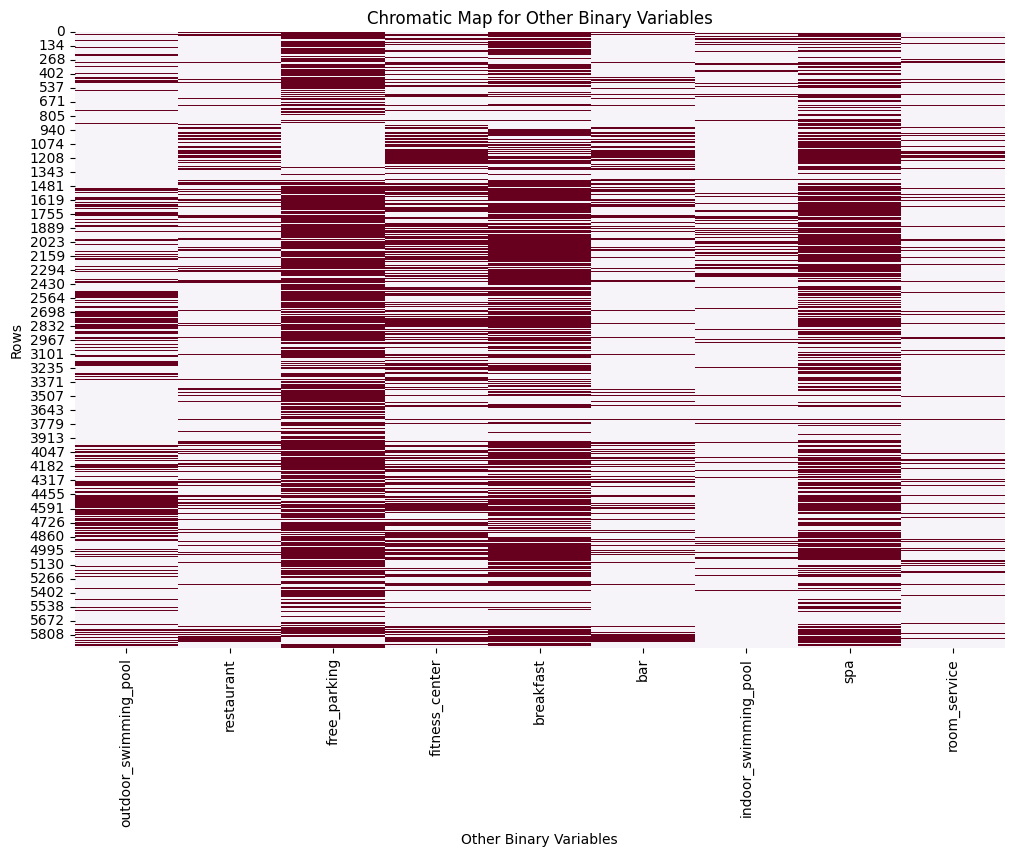

In [13]:
other_binary_cols = ['outdoor_swimming_pool', 'restaurant', 'free_parking', 'fitness_center', 'breakfast',
               'bar', 'indoor_swimming_pool', 'spa', 'room_service']


other_binary_df = df[other_binary_cols]


plt.figure(figsize=(12, 8))
sns.heatmap(other_binary_df, cmap='PuRd', cbar=False)
plt.title('Chromatic Map for Other Binary Variables')
plt.xlabel('Other Binary Variables')
plt.ylabel('Rows')
plt.show()



# We continued with the representation of hotel types according to their rating

we analyze the distribution of rating scores for each property type in the DataFrame. The following steps are executed:

Grouping and Aggregating Ratings: We group the DataFrame by the 'atnm' column (representing property types) and the 'rating' column. We then calculate the count of each rating score using value_counts() and reshape the resulting data using unstack(fill_value=0) to create a tabular structure.

Defining Property Types and Rating Scores: We extract the property types from the index of the grouped ratings DataFrame into the property_types variable. Similarly, we extract the rating scores from the columns of the DataFrame into the rating_scores variable.

Creating the Bar Plot: We create a bar plot using plt.bar() from Matplotlib. For each property type in property_types, we plot a bar chart representing the distribution of rating scores using the corresponding ratings from the grouped ratings DataFrame.

Customizing Labels and Title: We set the x-axis label using ax.set_xlabel(), the y-axis label using ax.set_ylabel(), and the title of the plot using ax.set_title(). Additionally, we add a legend to differentiate between the property types using ax.legend(). To improve readability, we rotate the x-axis labels by 45 degrees using plt.xticks(rotation=45).

Displaying the Plot: We use plt.show() to display the bar plot visualization on the screen.

By visualizing the distribution of rating scores for each property type, we can gain insights into the quality and performance of different types of properties. The bar plot allows us to compare the rating scores across different property types and identify any variations or patterns in the ratings.

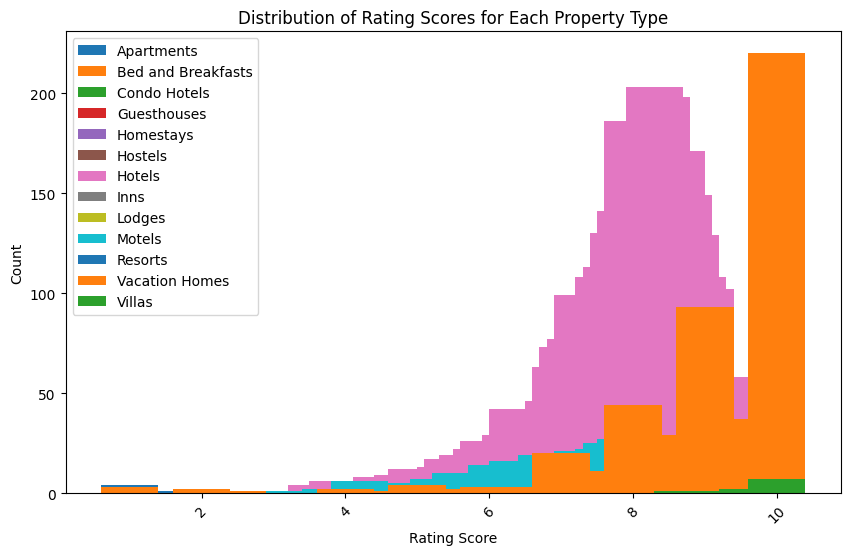

In [14]:
grouped_ratings = df.groupby('atnm')['rating'].value_counts().unstack(fill_value=0)


property_types = grouped_ratings.index
rating_scores = grouped_ratings.columns


fig, ax = plt.subplots(figsize=(10, 6))

for i, prop in enumerate(property_types):
    ratings = grouped_ratings.loc[prop]
    ax.bar(rating_scores, ratings, label=prop)

ax.set_xlabel('Rating Score')
ax.set_ylabel('Count')
ax.set_title('Distribution of Rating Scores for Each Property Type')
ax.legend()
plt.xticks(rotation=45)
plt.show()


# Distribution of Ratings for Each Property Type

In this section, we examine the distribution of ratings for each property type in the DataFrame. The following steps are performed:

Grouping and Aggregating Ratings: We group the DataFrame by the 'atnm' column (representing property types) and the 'rating' column. Using value_counts(), we calculate the count of each rating score for each property type. The resulting data is reshaped into a tabular structure using unstack(fill_value=0) and stored in the grouped_ratings variable.

Plotting the Distribution: For each property type in grouped_ratings, we create a separate bar plot to visualize the distribution of ratings. The iterrows() function is used to iterate over each row of grouped_ratings, where each row contains the ratings for a specific property type. Inside the loop, we create a new figure using plt.figure(figsize=(10, 6)) and plot the ratings as a bar chart using ratings.plot(kind='bar', width=0.8).

Customizing Labels and Title: We set the x-axis label using plt.xlabel(), the y-axis label using plt.ylabel(), and the title of the plot using plt.title(). The x-axis labels are not rotated (rotation=0) to maintain clarity.

Displaying the Plot: We use plt.show() to display each individual bar plot for every property type.

By visualizing the distribution of ratings for each property type, we can gain insights into the variation and concentration of ratings within different categories. Each bar plot provides a specific property type's rating distribution, allowing us to analyze the ratings' spread, central tendency, and potential outliers.

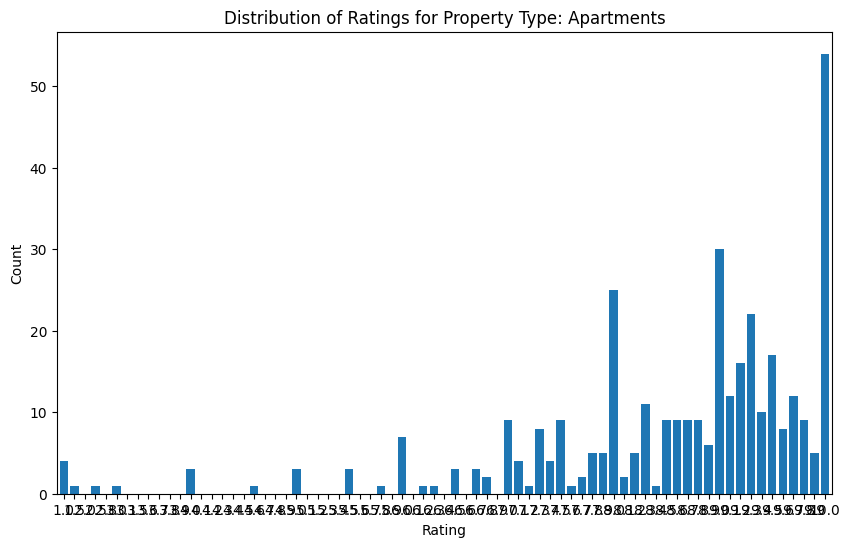

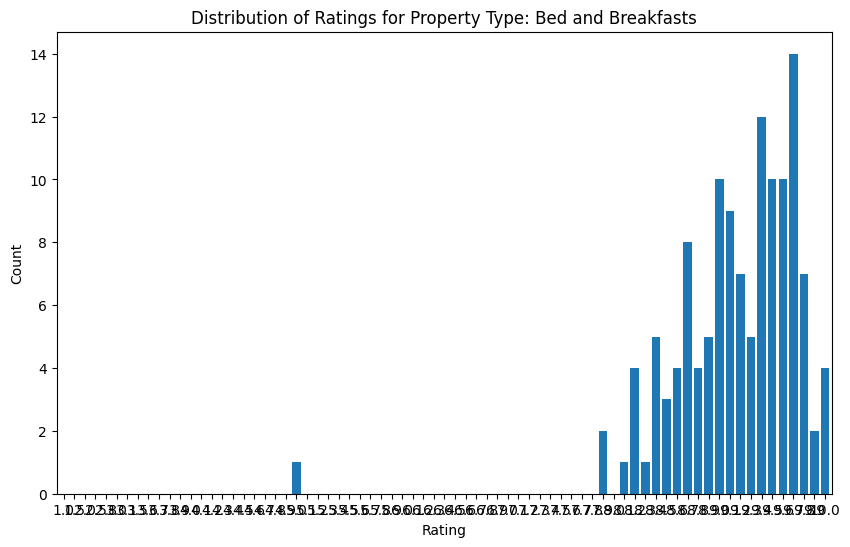

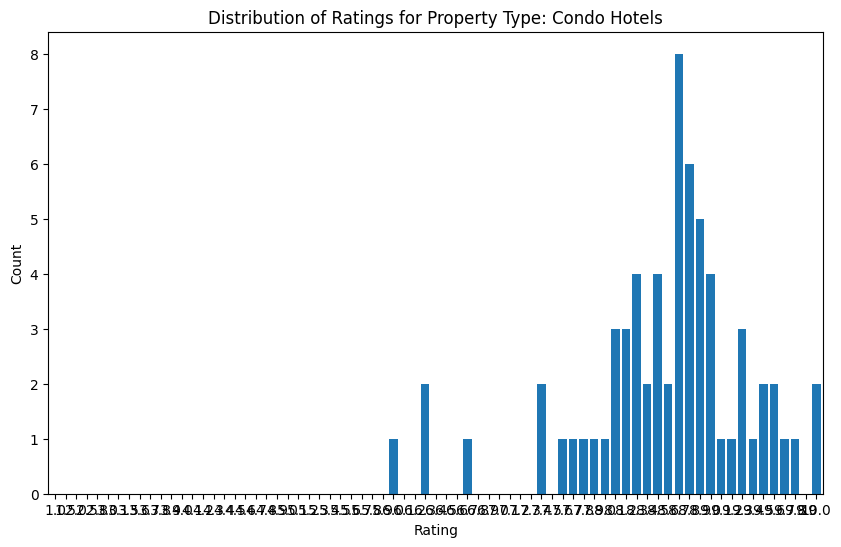

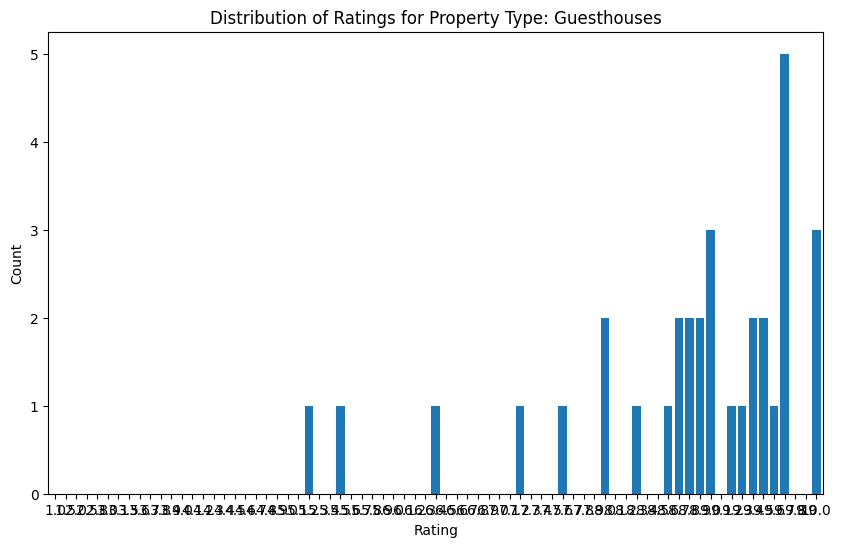

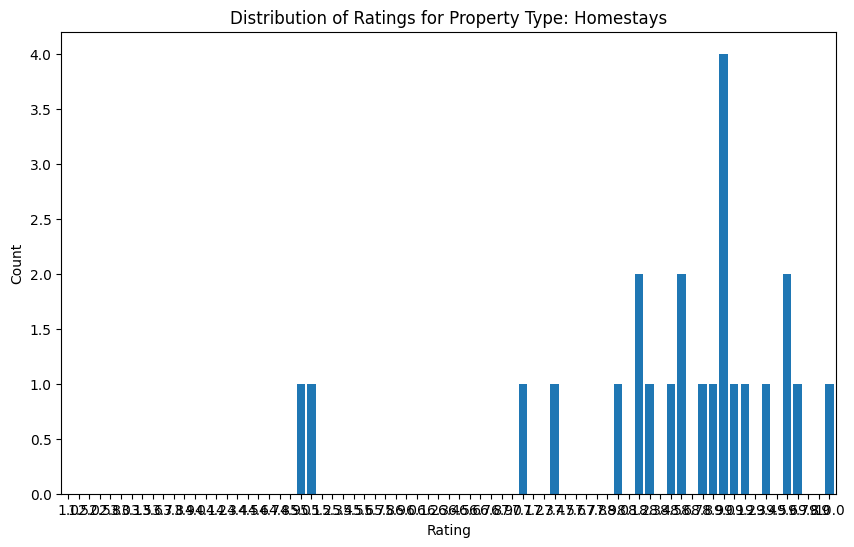

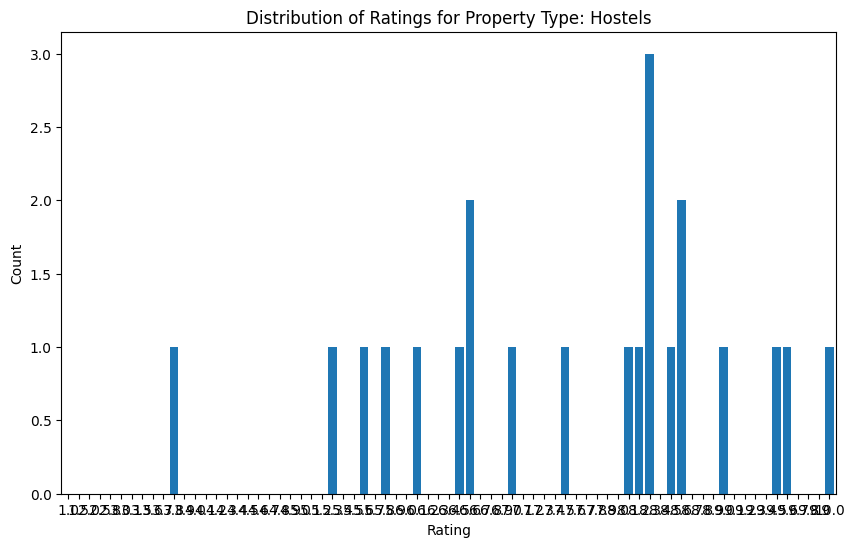

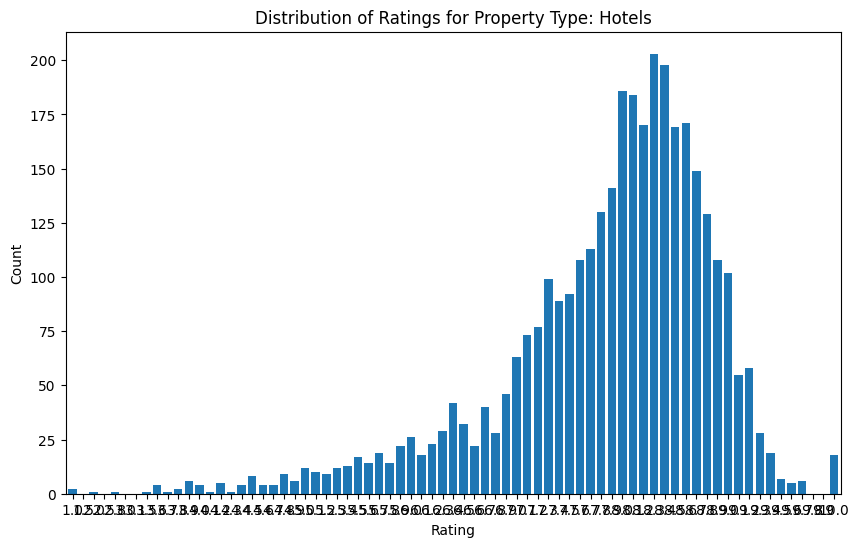

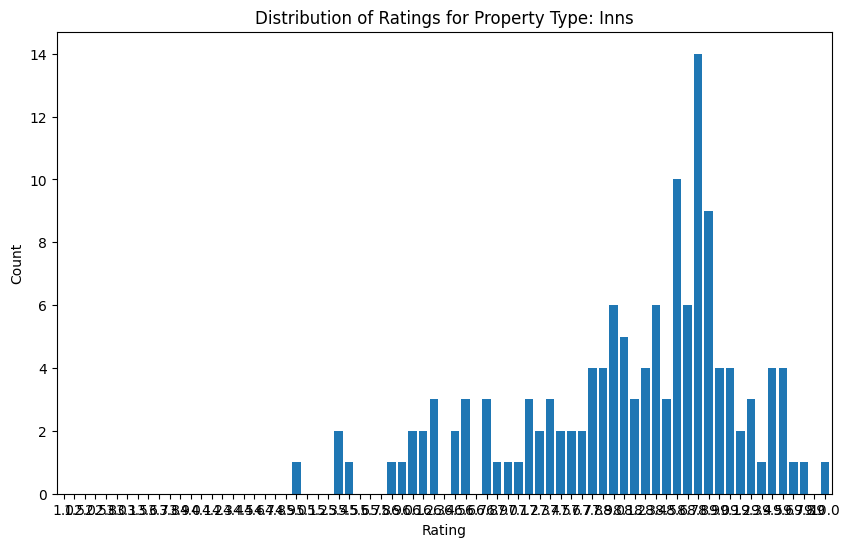

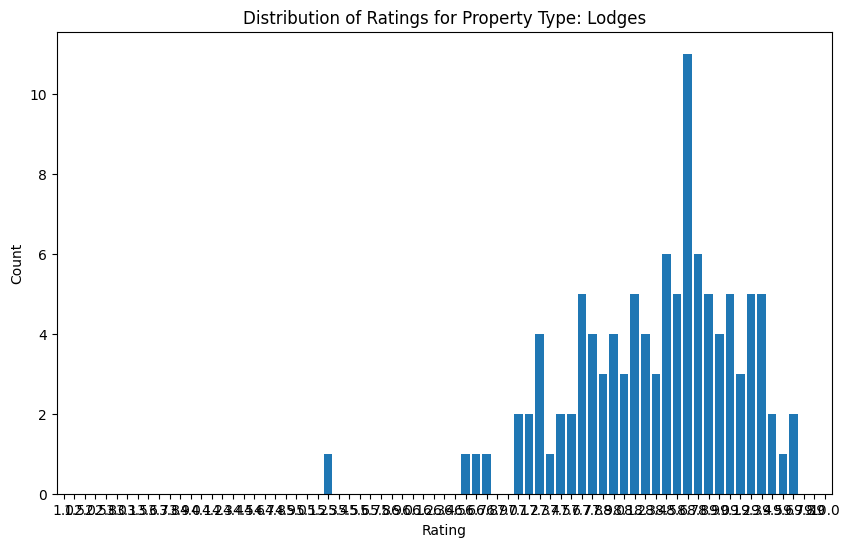

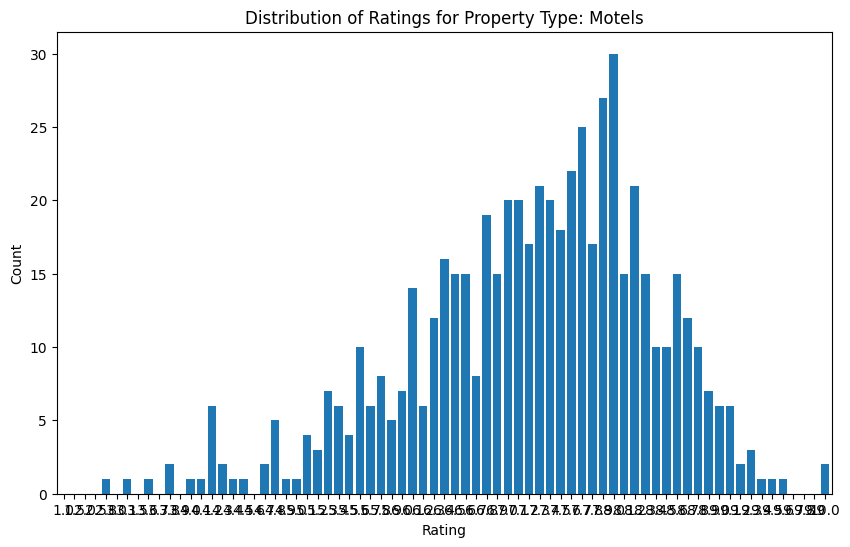

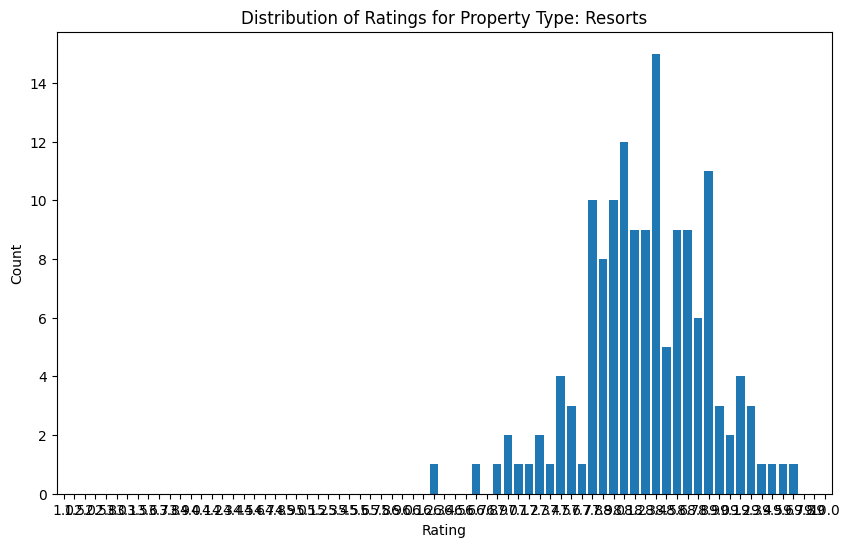

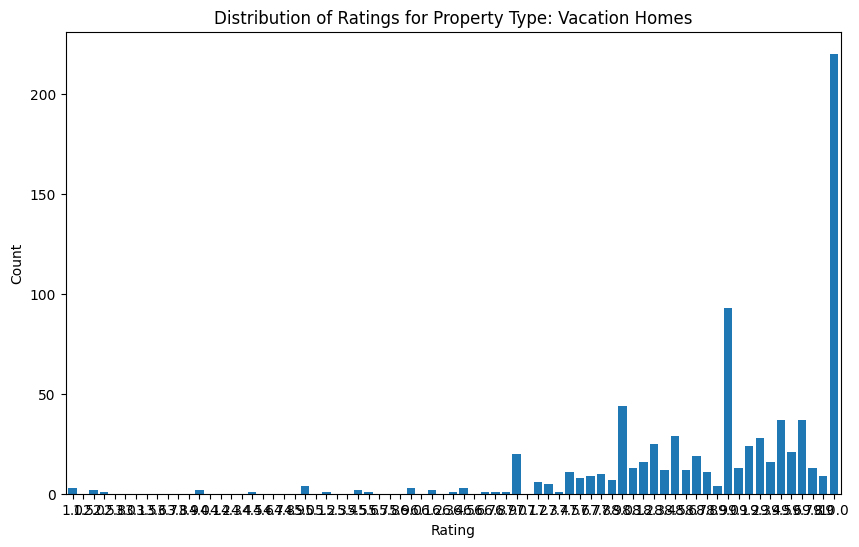

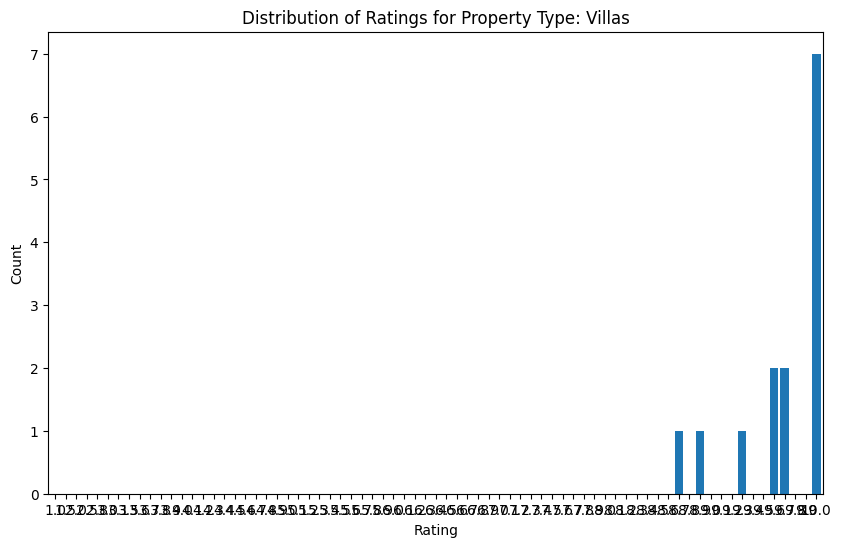

In [15]:

grouped_ratings = df.groupby('atnm')['rating'].value_counts().unstack(fill_value=0)


for prop, ratings in grouped_ratings.iterrows():
    plt.figure(figsize=(10, 6))
    ratings.plot(kind='bar', width=0.8)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(f'Distribution of Ratings for Property Type: {prop}')
    plt.xticks(rotation=0)
    plt.show()

# Average Ratings by State on US Map

we visualize the average ratings for each state on a map of the United States. The following steps are performed:

State Coordinates: We define a dictionary called state_coordinates, which contains the latitude and longitude coordinates for each state in the United States.

Calculating Average Ratings: We group the DataFrame by the 'region_name' column (representing states) and calculate the mean of the 'rating' column using groupby('region_name')['rating'].mean(). The resulting data is stored in the state_avg_ratings DataFrame, which consists of two columns: 'region_name' and 'rating'.

Creating a US Map: We create an instance of the folium.Map object with an initial center location and zoom level representing the United States.

Plotting Average Ratings: For each row in the state_avg_ratings DataFrame, we retrieve the state name and average rating. We then check if the state name exists in the state_coordinates dictionary. If it does, we determine the color of the circle marker based on the average rating: green for ratings greater than or equal to 8.0, orange for ratings greater than or equal to 7.0, and red for other ratings.

Adding Circle Markers: We create a folium.CircleMarker for each state, using the state's coordinates, average rating, and determined color. The circle marker's size, color, and opacity are customized. Additionally, a tooltip is added to display the state name and average rating when hovering over a marker.

Adding Circle Markers to the US Map: We add each circle marker to the us_map object.

By visualizing the average ratings on a US map, we can quickly identify states with higher or lower average ratings. The color-coded circle markers provide a visual representation of the ratings, allowing for easy comparison and identification of states with exceptional ratings. Hovering over a marker provides additional information about the state name and its corresponding average rating.

In [16]:
import folium


state_coordinates = {
    'Alabama': (32.806671, -86.791130),
    'Alaska': (61.370716, -152.404419),
    'Arizona': (33.729759, -111.431221),
    'Arkansas': (34.969704, -92.373123),
    'California': (36.116203, -119.681564),
    'Colorado': (39.059811, -105.311104),
    'Connecticut': (41.597782, -72.755371),
    'Delaware': (39.318523, -75.507141),
    'Florida': (27.766279, -81.686783),
    'Georgia': (33.040619, -83.643074),
    'Hawaii': (21.094318, -157.498337),
    'Idaho': (44.240459, -114.478828),
    'Illinois': (40.349457, -88.986137),
    'Indiana': (39.849426, -86.258278),
    'Iowa': (42.011539, -93.210526),
    'Kansas': (38.526600, -96.726486),
    'Kentucky': (37.668140, -84.670067),
    'Louisiana': (31.169546, -91.867805),
    'Maine': (44.693947, -69.381927),
    'Maryland': (39.063946, -76.802101),
    'Massachusetts': (42.230171, -71.530106),
    'Michigan': (43.326618, -84.536095),
    'Minnesota': (45.694454, -93.900192),
    'Mississippi': (32.741646, -89.678696),
    'Missouri': (38.456085, -92.288368),
    'Montana': (46.921925, -110.454353),
    'Nebraska': (41.125370, -98.268082),
    'Nevada': (38.313515, -117.055374),
    'New Hampshire': (43.452492, -71.563896),
    'New Jersey': (40.298904, -74.521011),
    'New Mexico': (34.840515, -106.248482),
    'New York State': (42.165726, -74.948051),
    'North Carolina': (35.630066, -79.806419),
    'North Dakota': (47.528912, -99.784012),
    'Ohio': (40.388783, -82.764915),
    'Oklahoma': (35.565342, -96.928917),
    'Oregon': (44.572021, -122.070938),
    'Pennsylvania': (40.590752, -77.209755),
    'Rhode Island': (41.680893, -71.511780),
    'South Carolina': (33.856892, -80.945007),
    'South Dakota': (44.299782, -99.438828),
    'Tennessee': (35.747845, -86.692345),
    'Texas': (31.054487, -97.563461),
    'Utah': (40.150032, -111.862434),
    'Vermont': (44.045876, -72.710686),
    'Virginia': (37.769337, -78.169968),
    'Washington State': (47.400902, -121.490494),
    'West Virginia': (38.491226, -80.954481),
    'Wisconsin': (44.268543, -89.616508),
    'Wyoming': (42.755966, -107.302490),
}


state_avg_ratings = df.groupby('region_name')['rating'].mean().reset_index()


us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)


for _, row in state_avg_ratings.iterrows():
    state = row['region_name']  
    avg_rating = row['rating']  

    
    coordinates = state_coordinates.get(state)

    if coordinates:
        color = 'red'  
        if avg_rating >= 8.0:
            color = 'green'
        elif avg_rating >= 7.0:
            color = 'orange'

        
        folium.CircleMarker(
            location=coordinates,
            radius=10,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            tooltip=f"{state}<br>Avg Rating: {avg_rating:.2f}",  # Display the state name and average rating as a tooltip
        ).add_to(us_map)


us_map

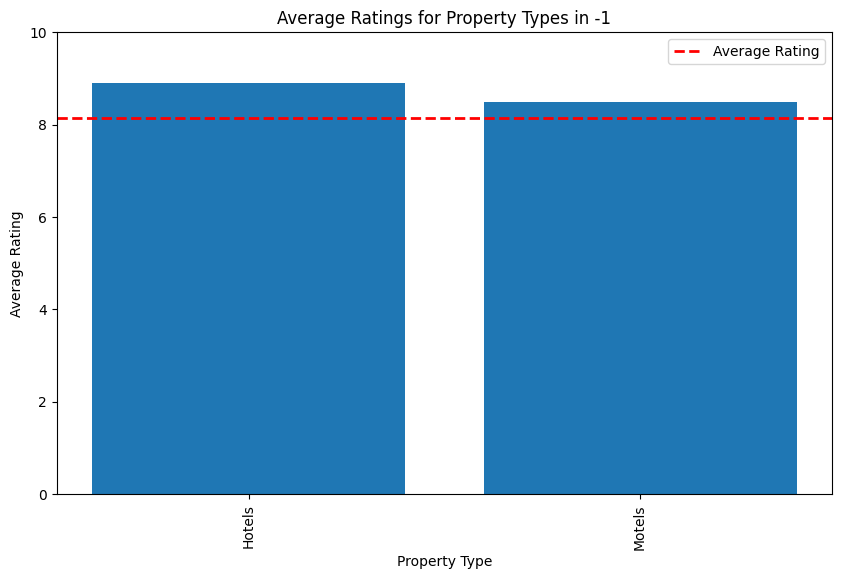

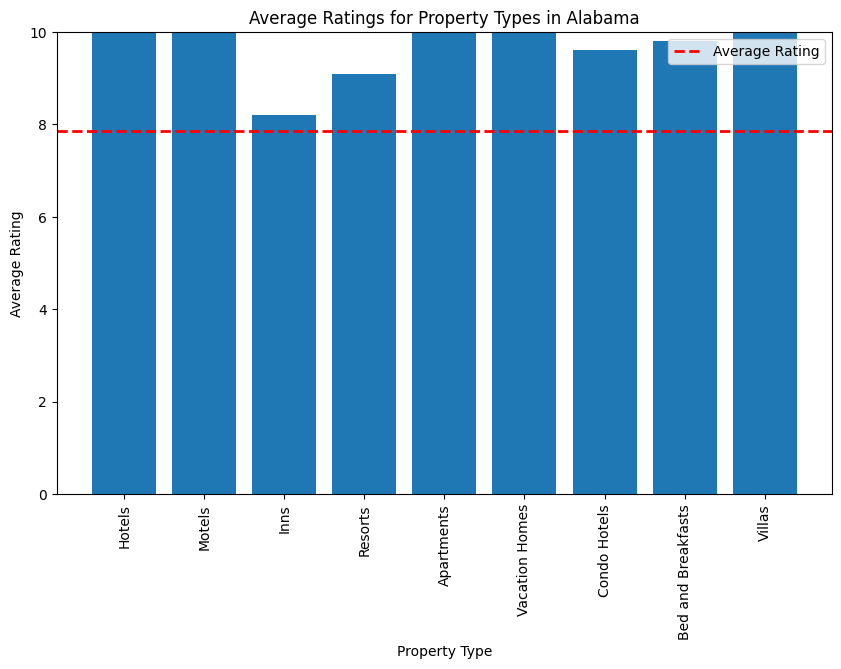

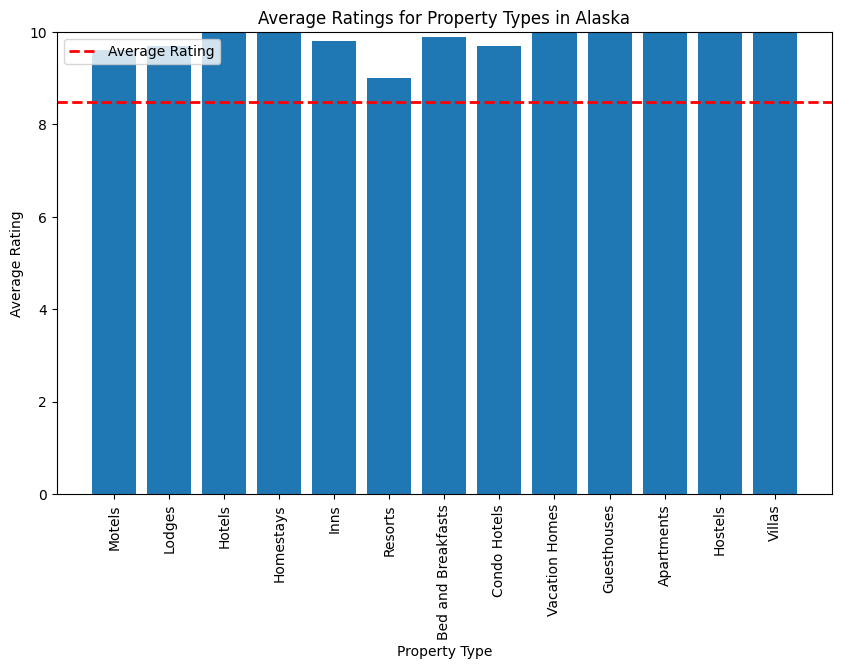

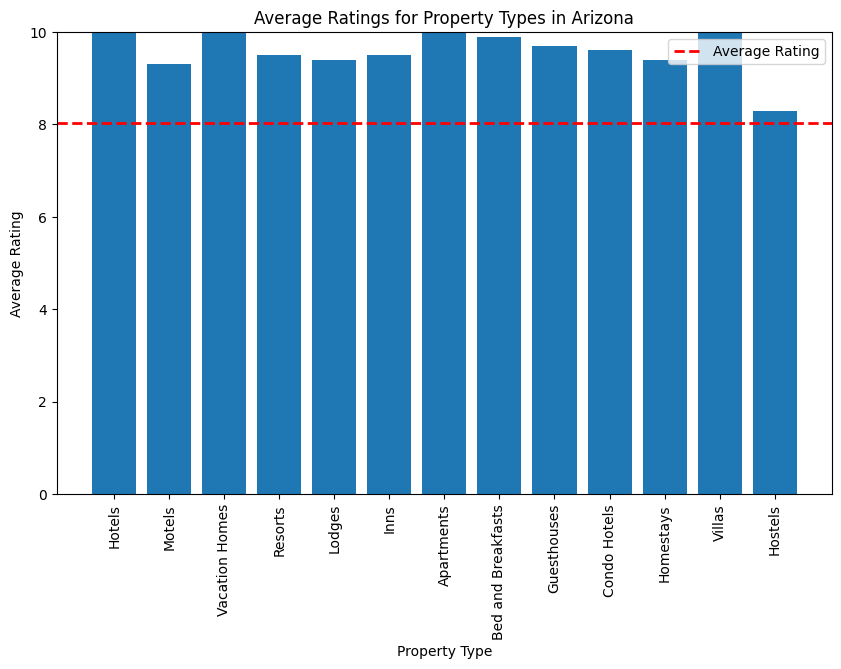

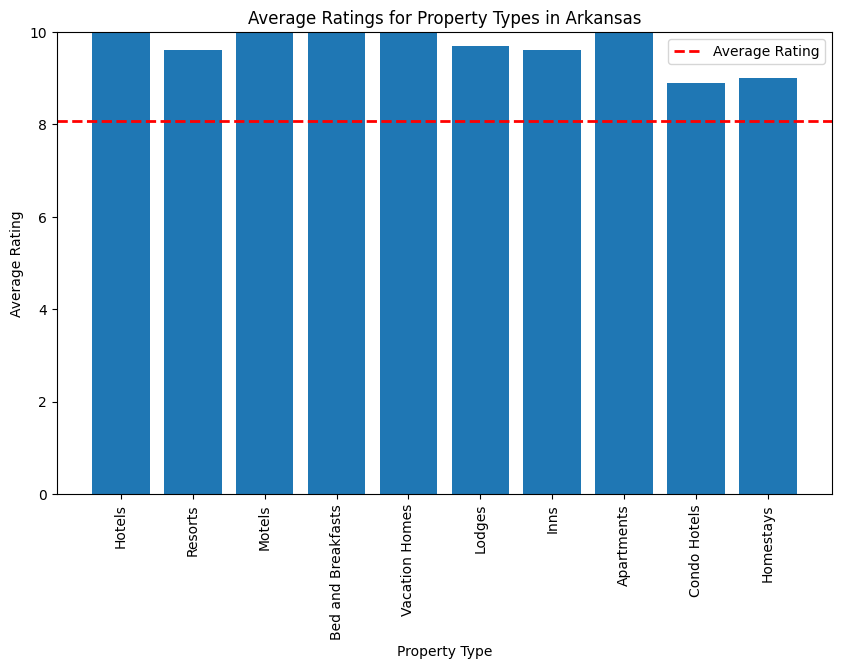

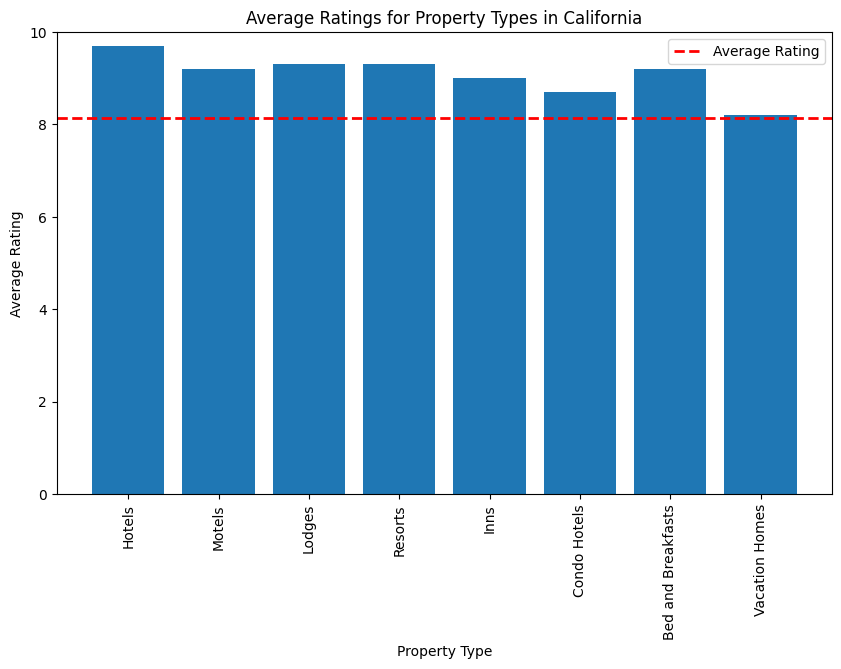

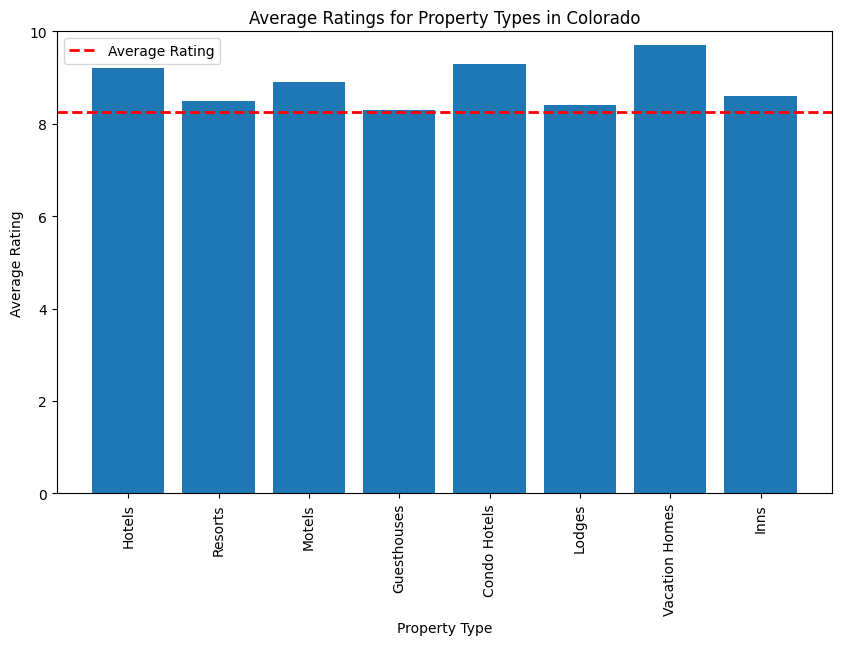

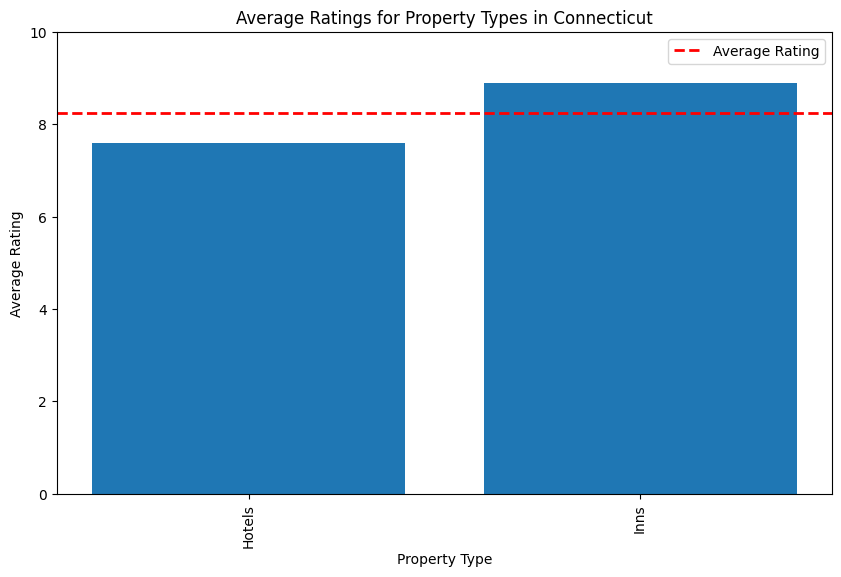

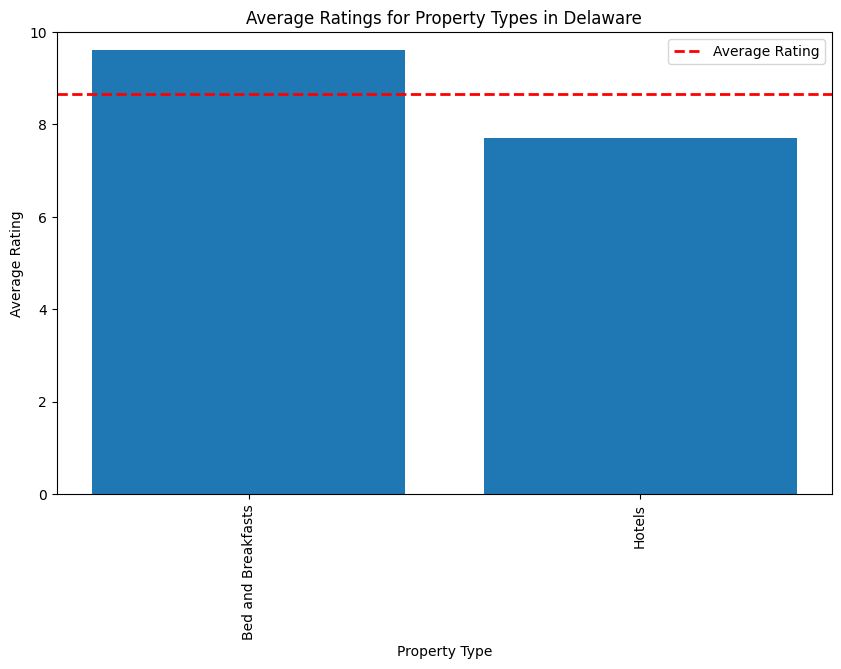

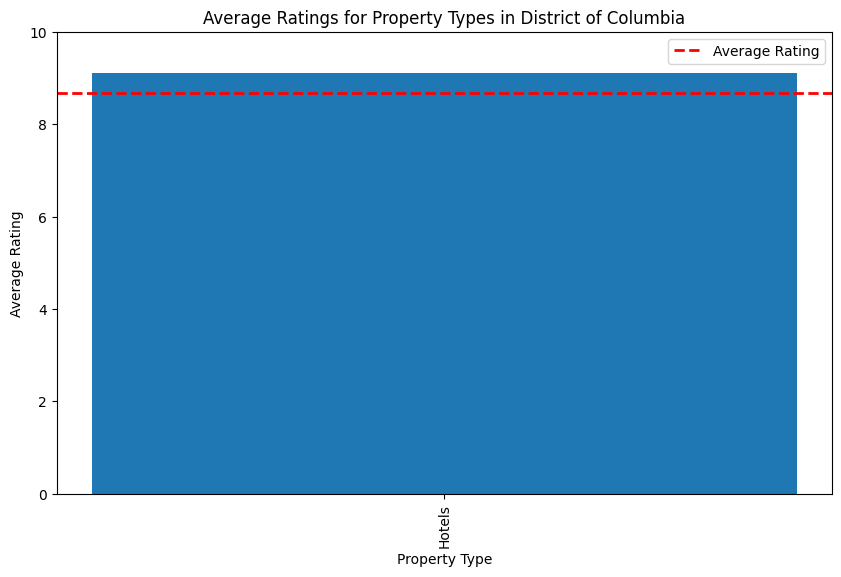

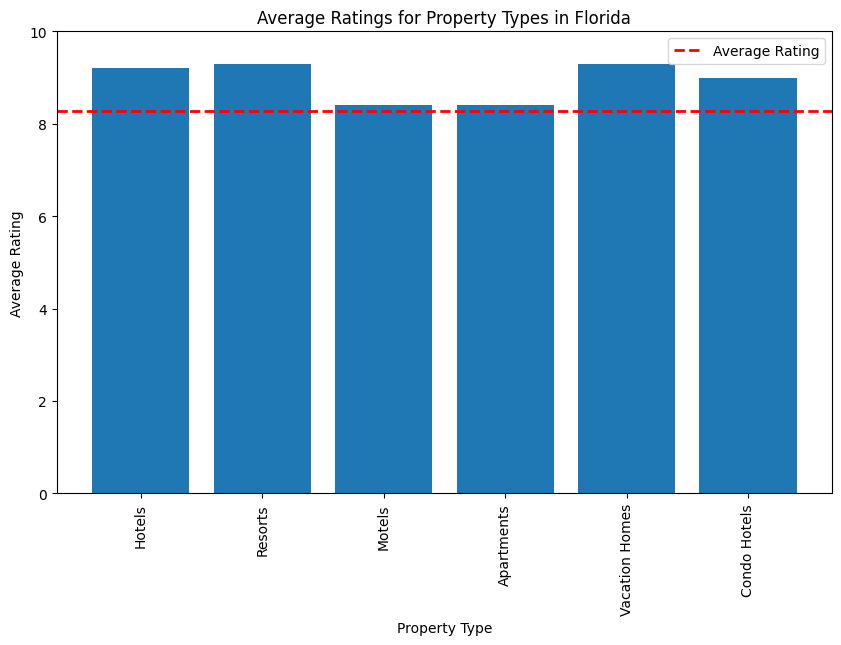

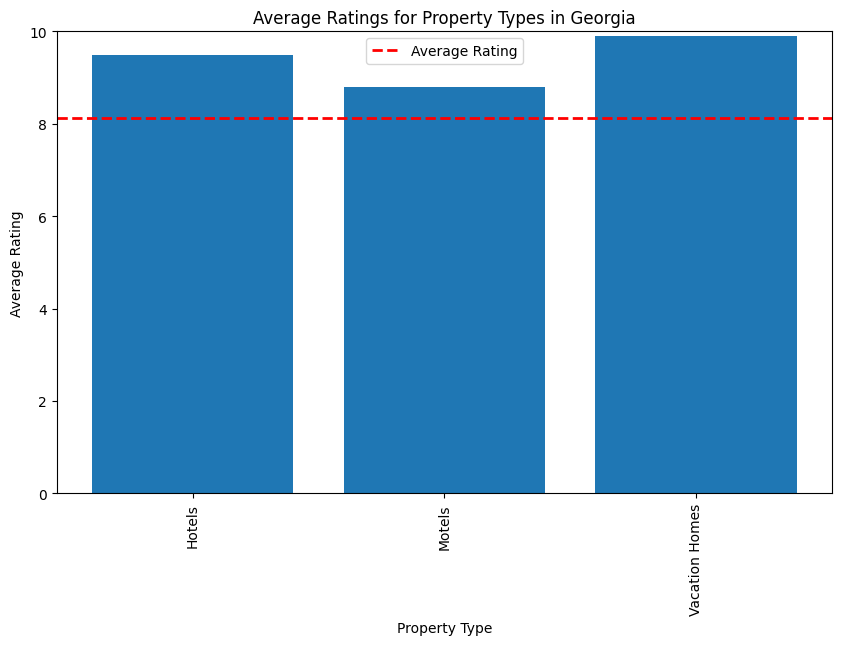

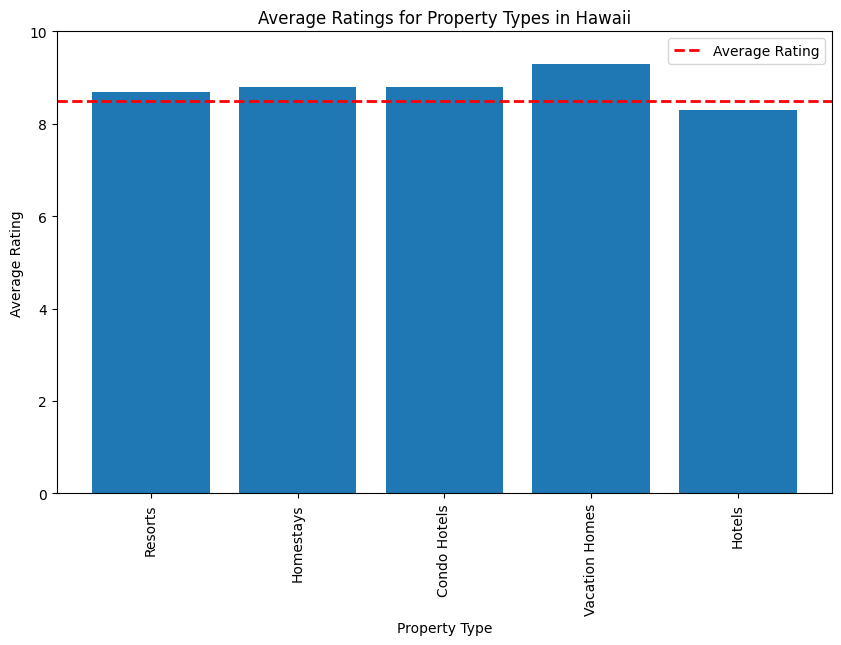

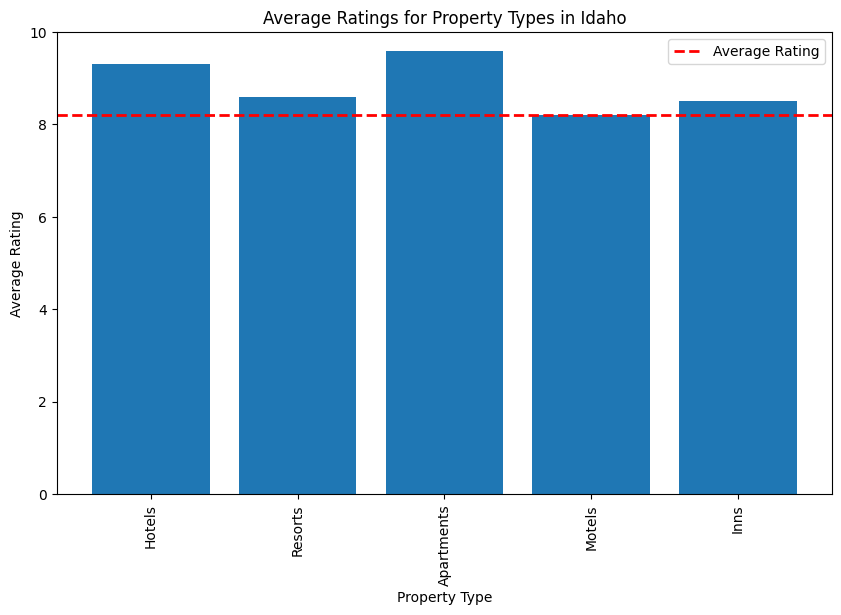

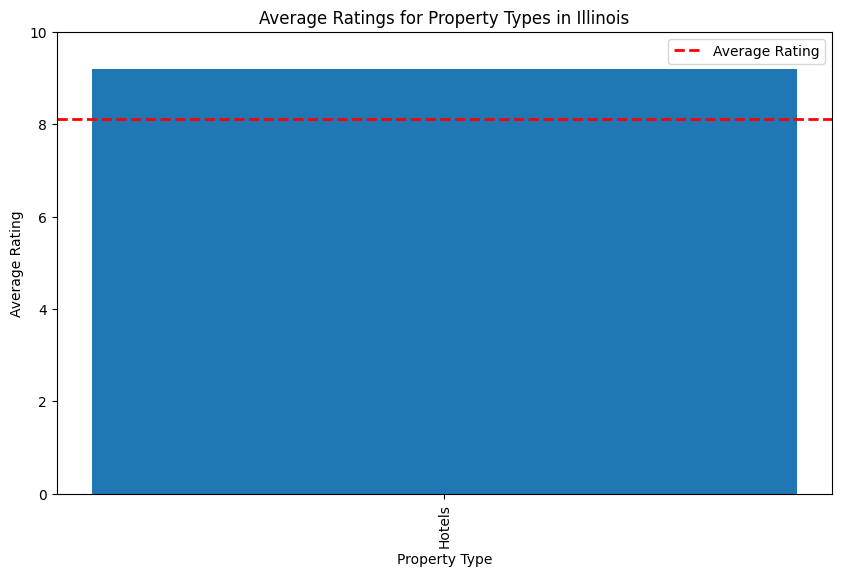

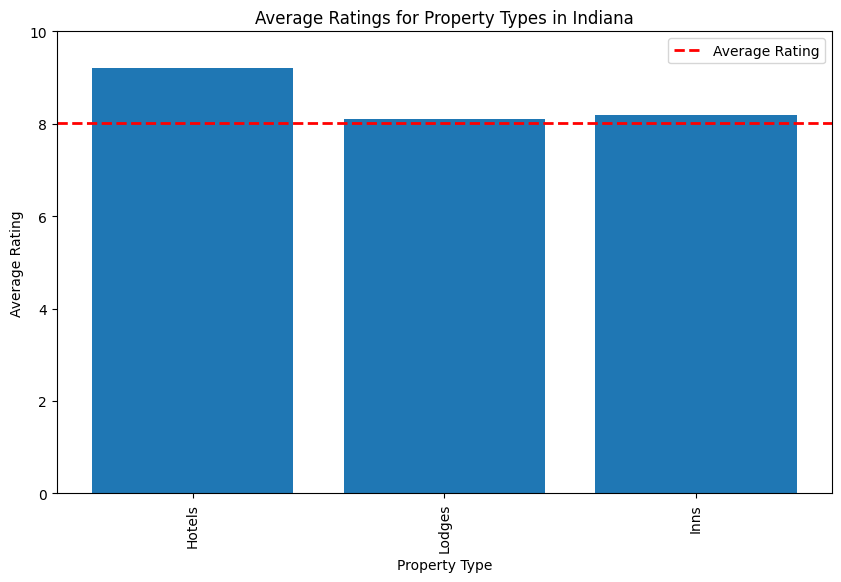

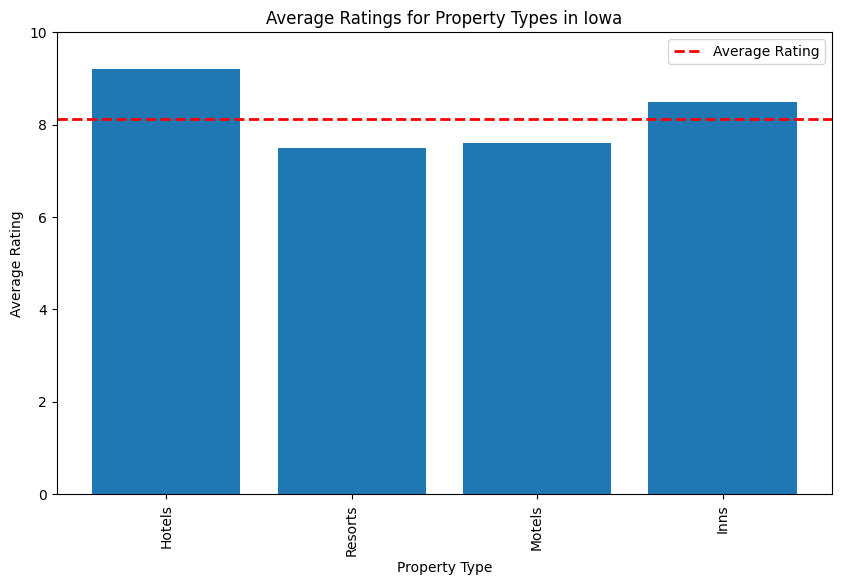

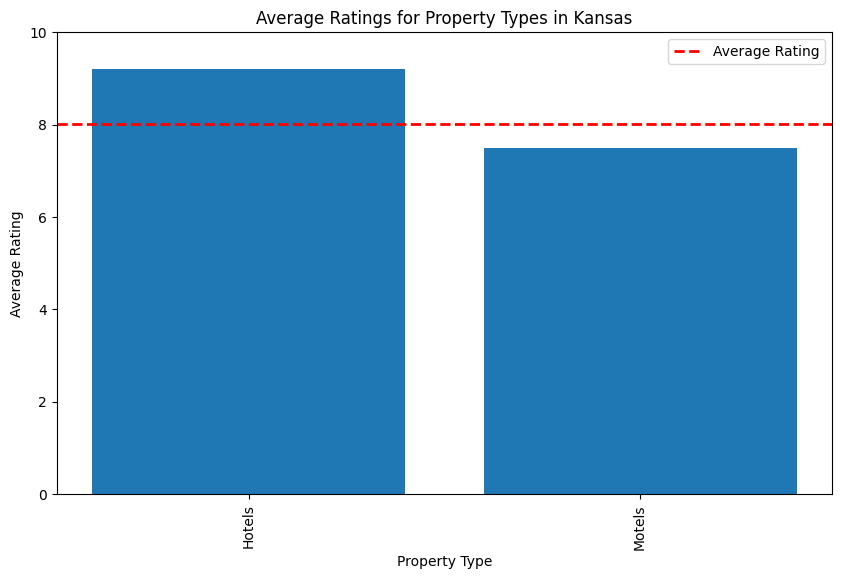

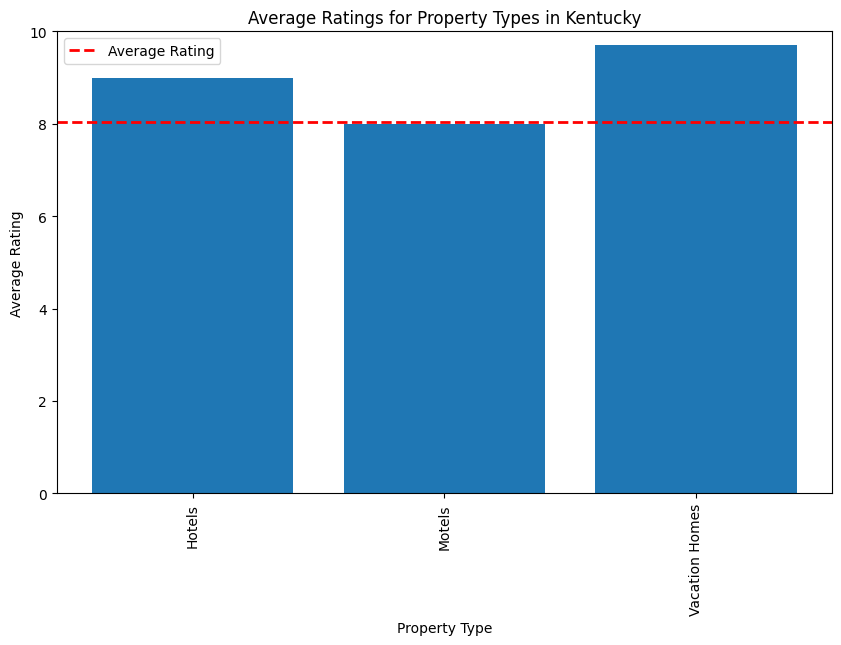

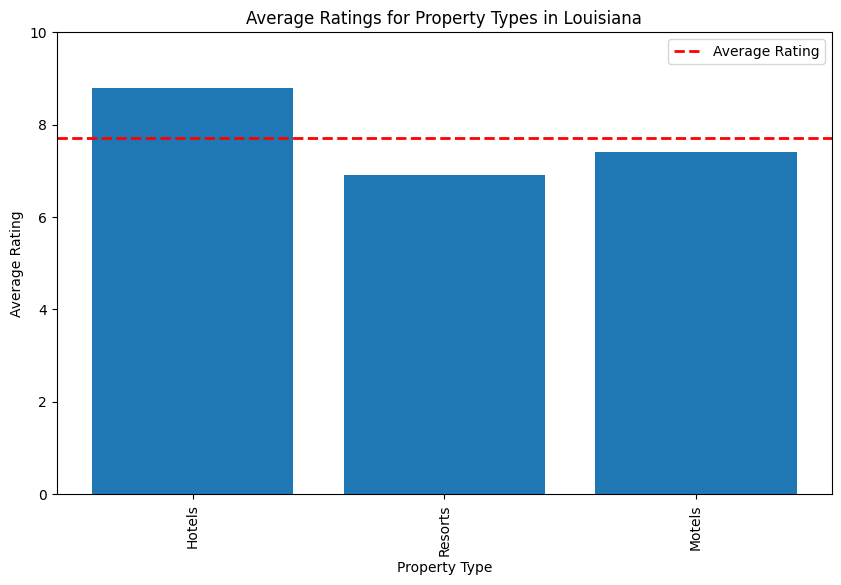

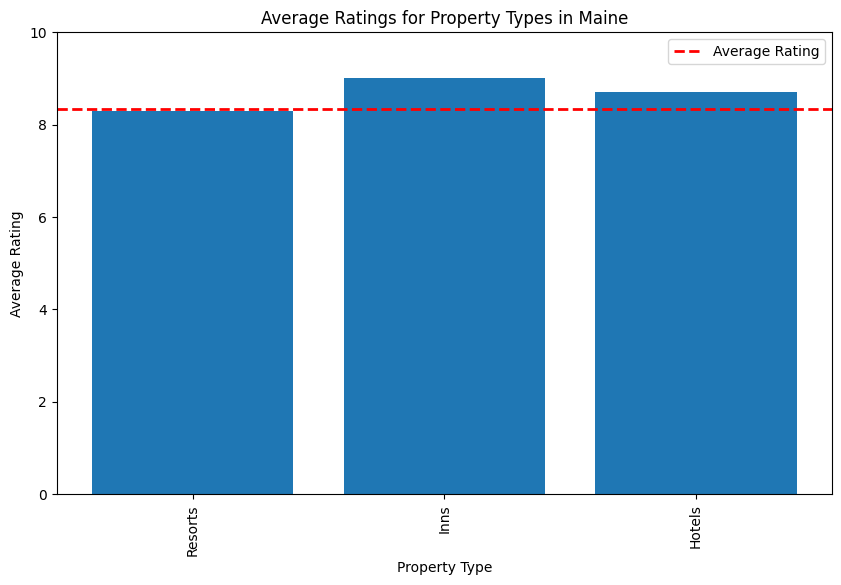

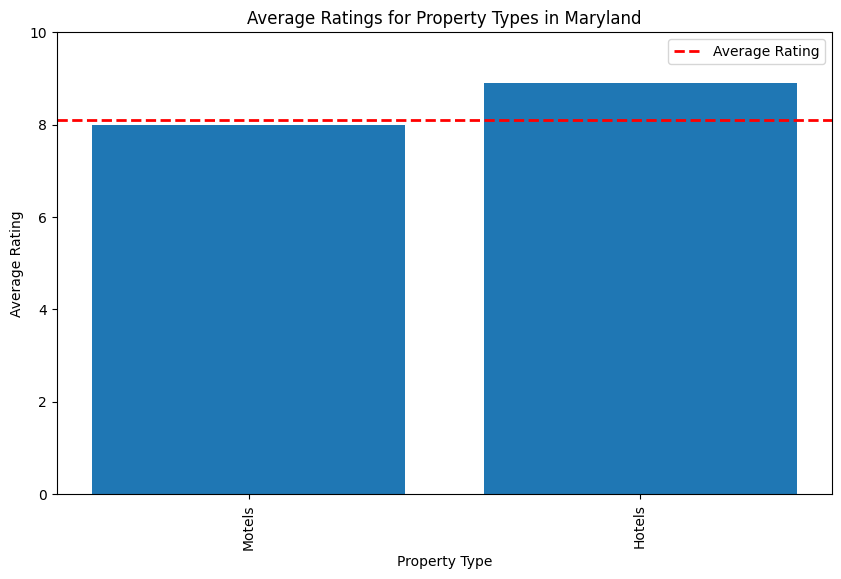

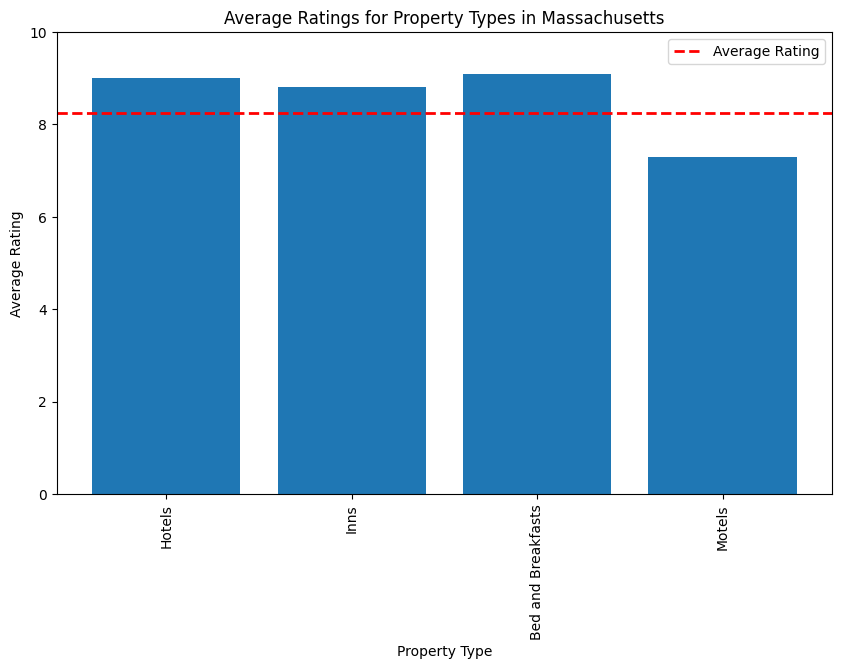

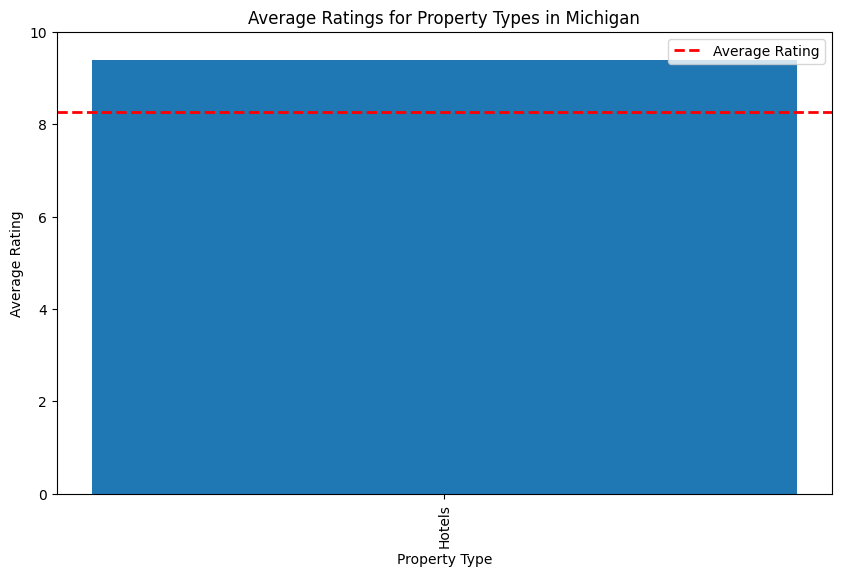

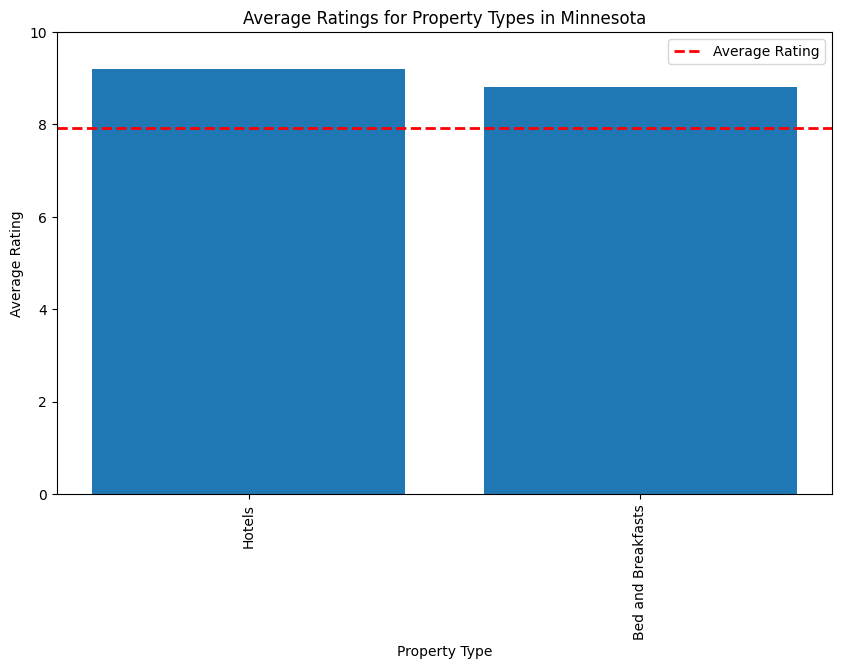

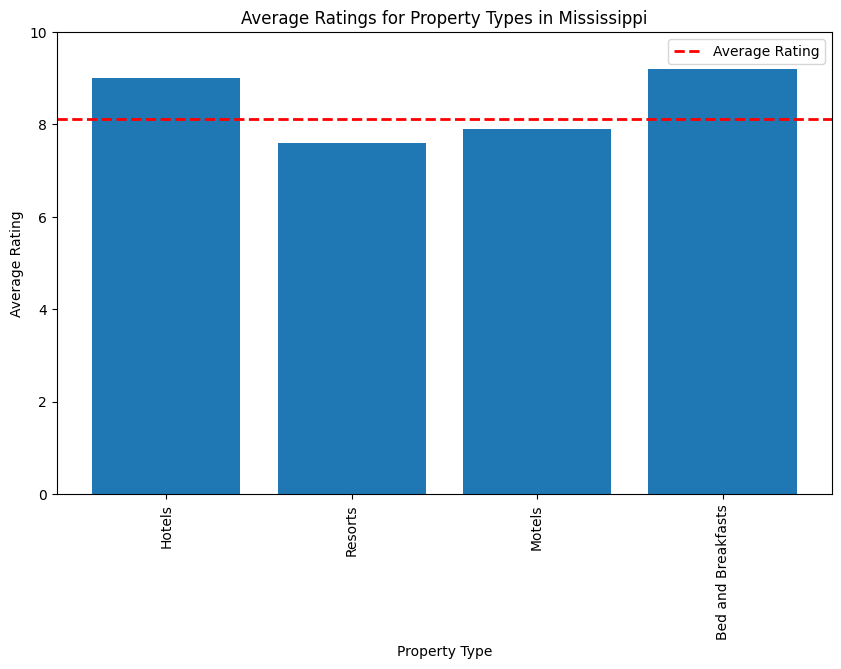

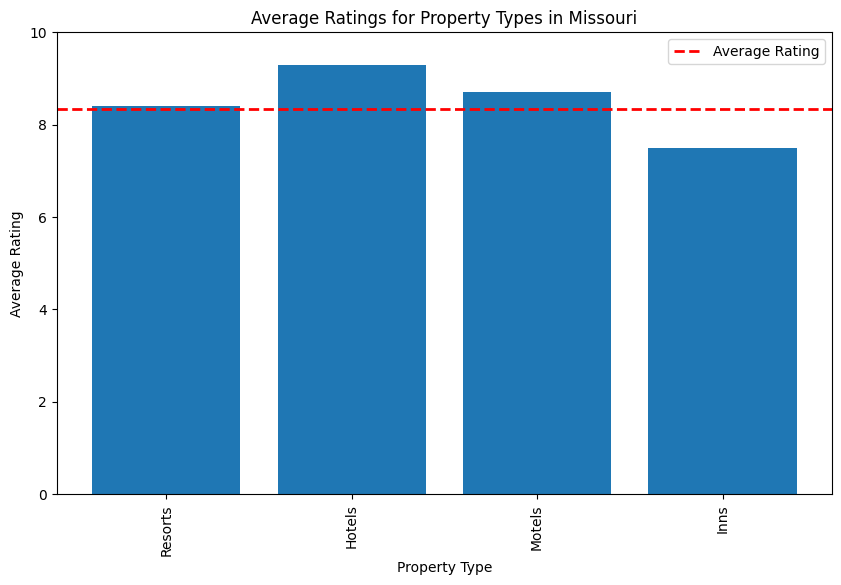

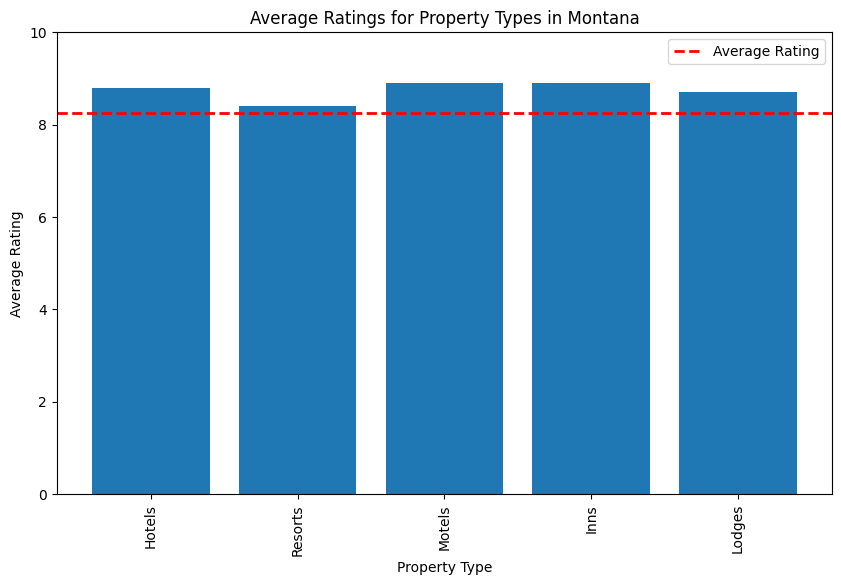

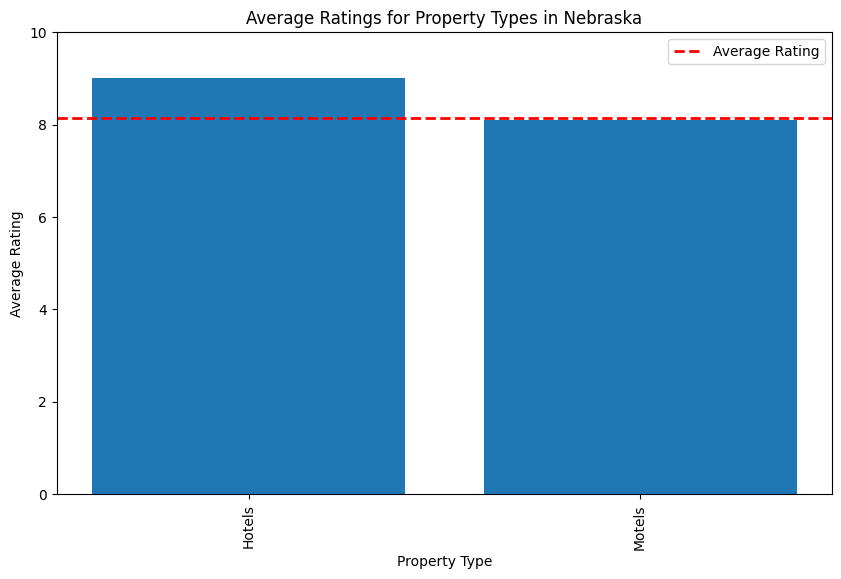

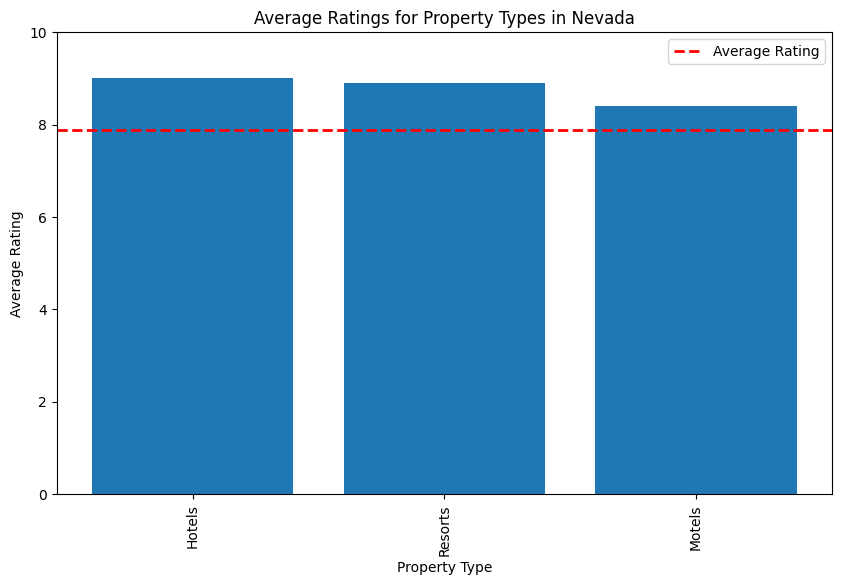

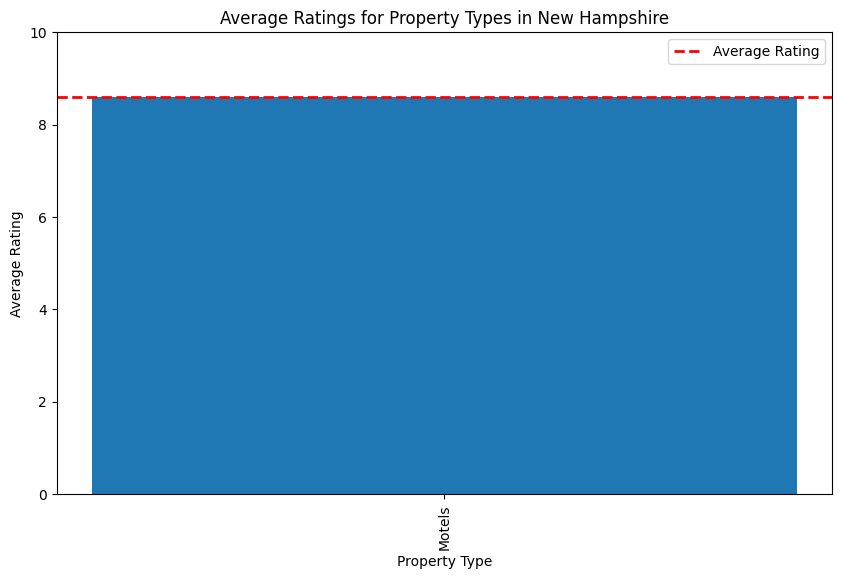

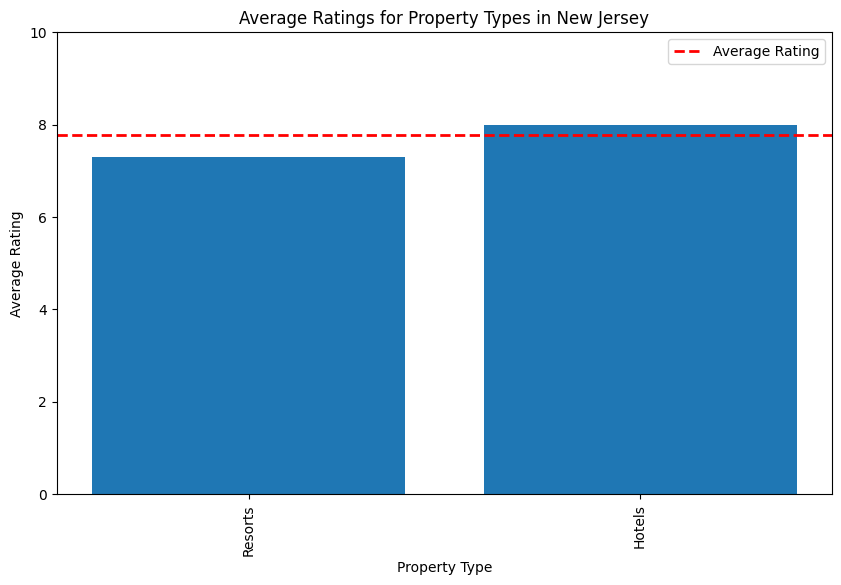

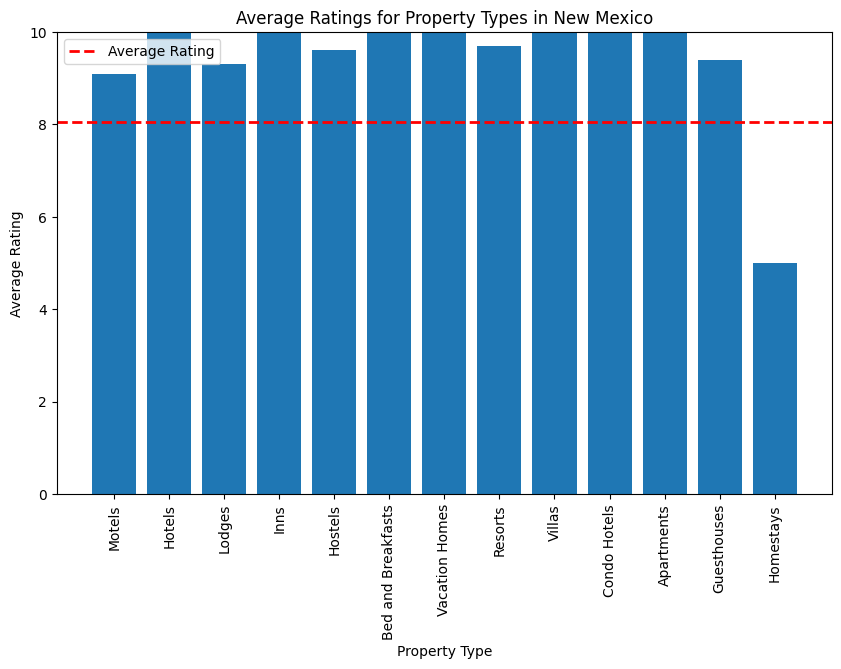

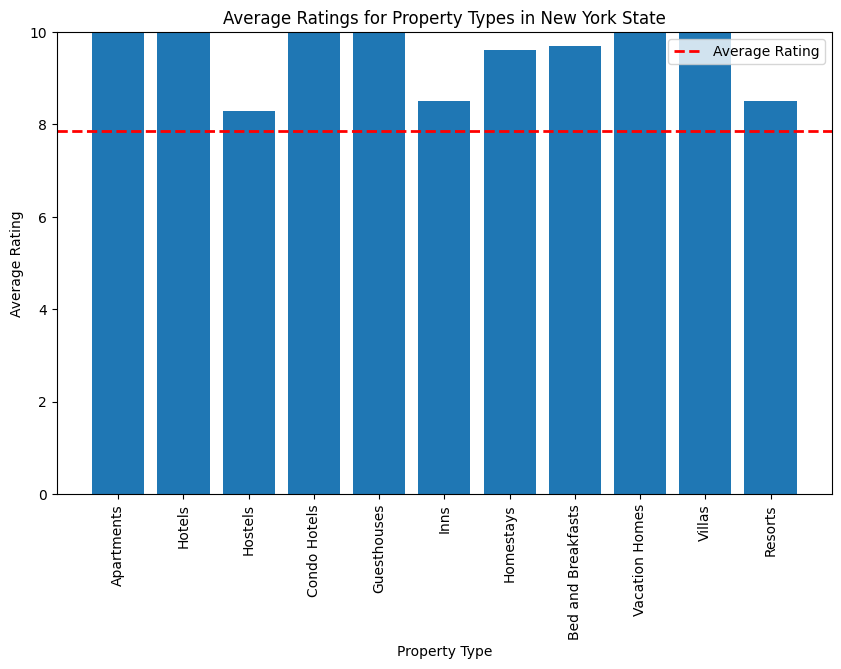

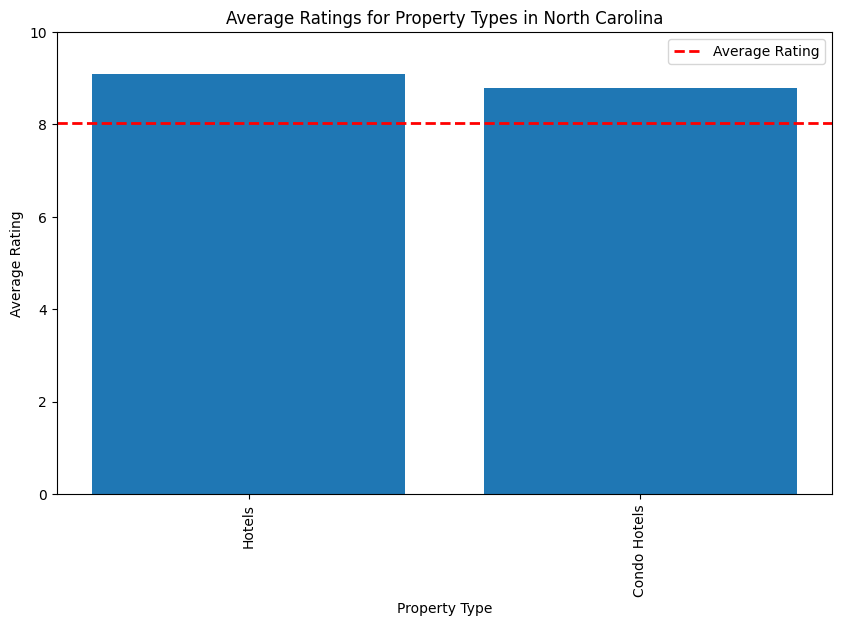

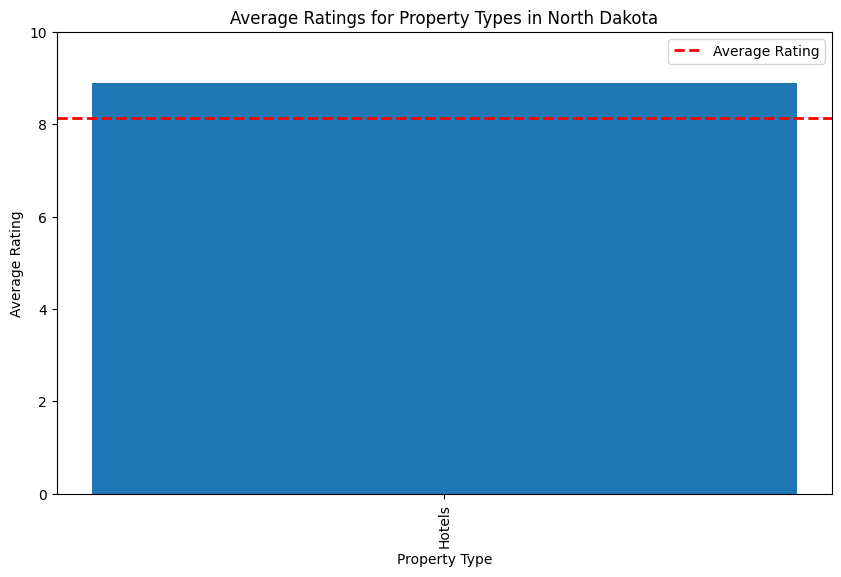

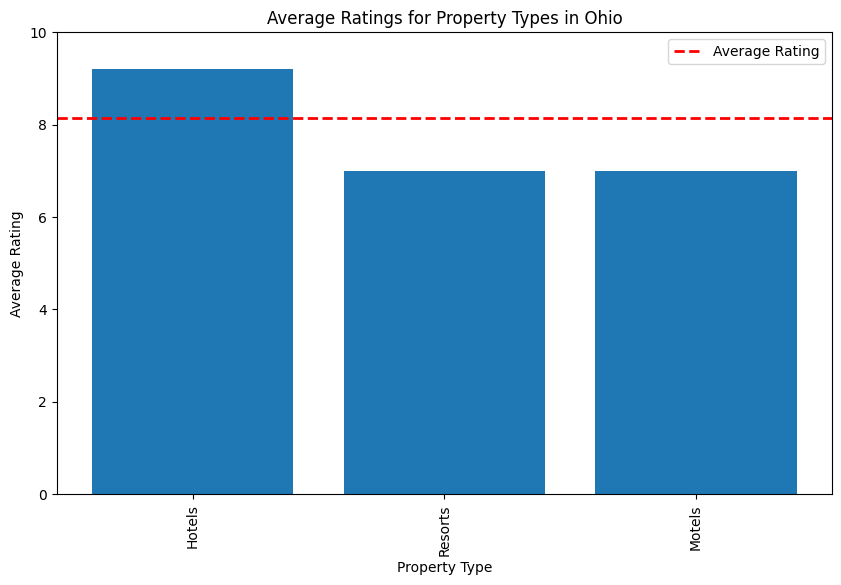

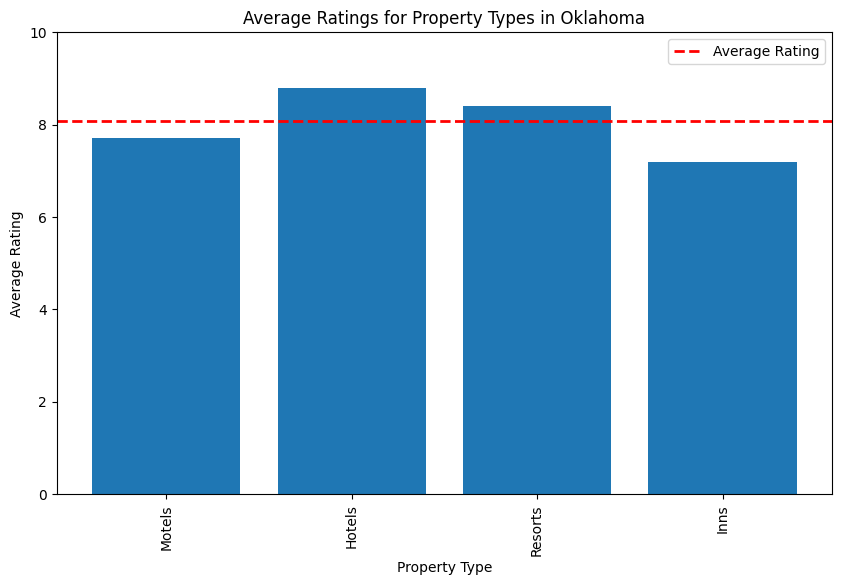

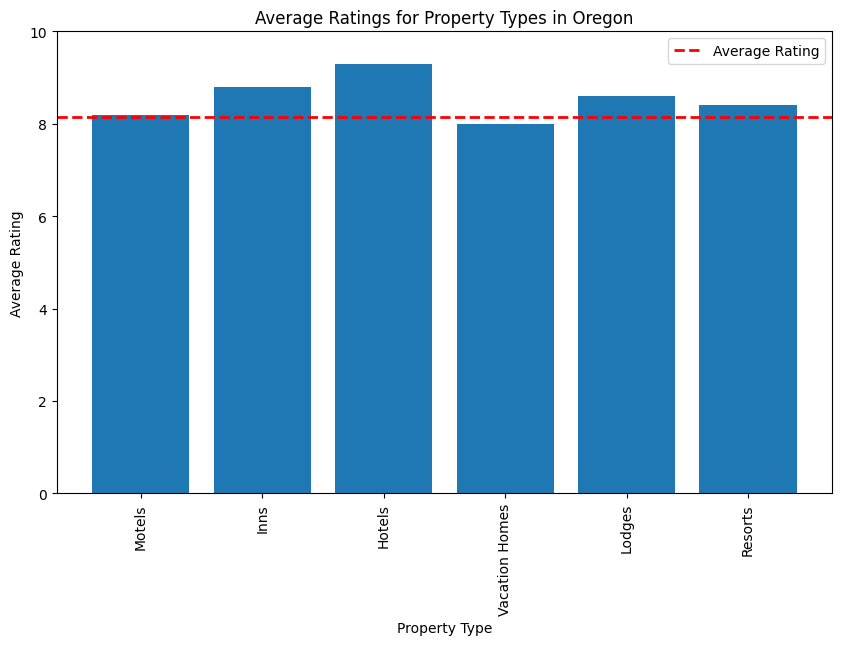

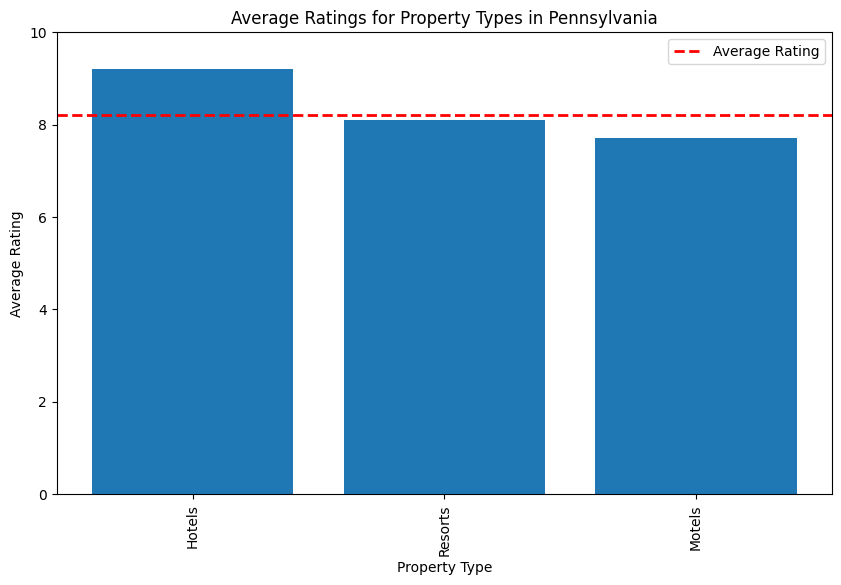

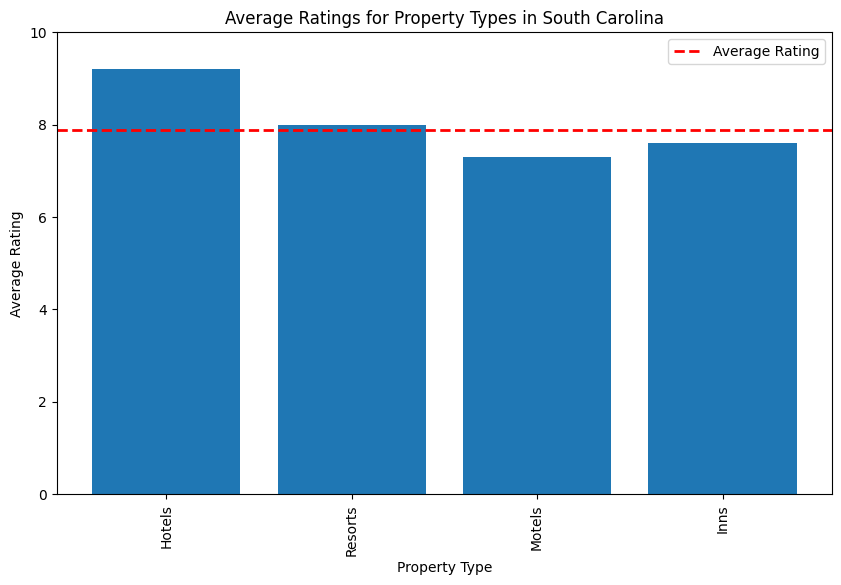

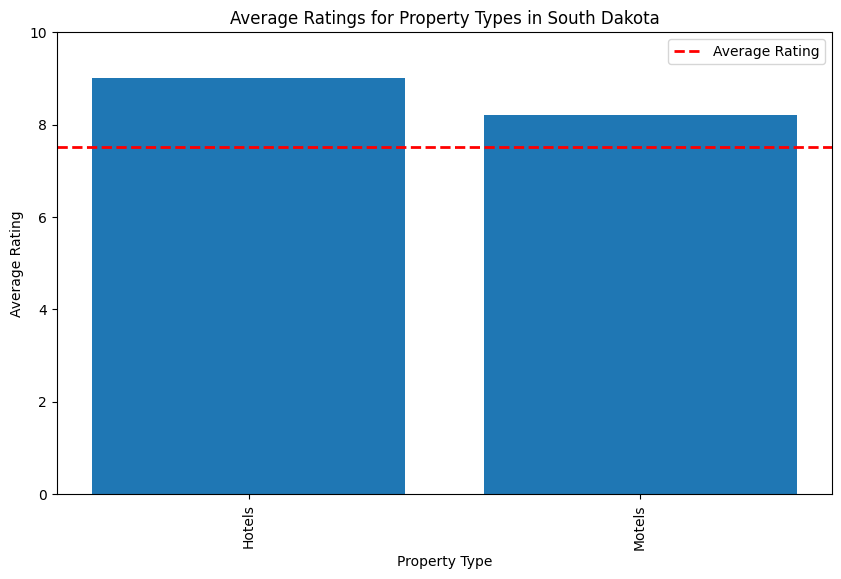

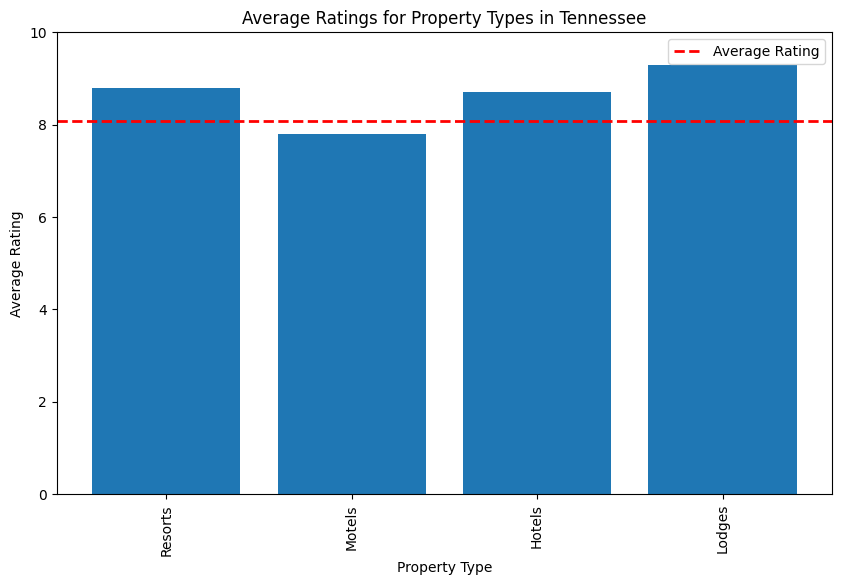

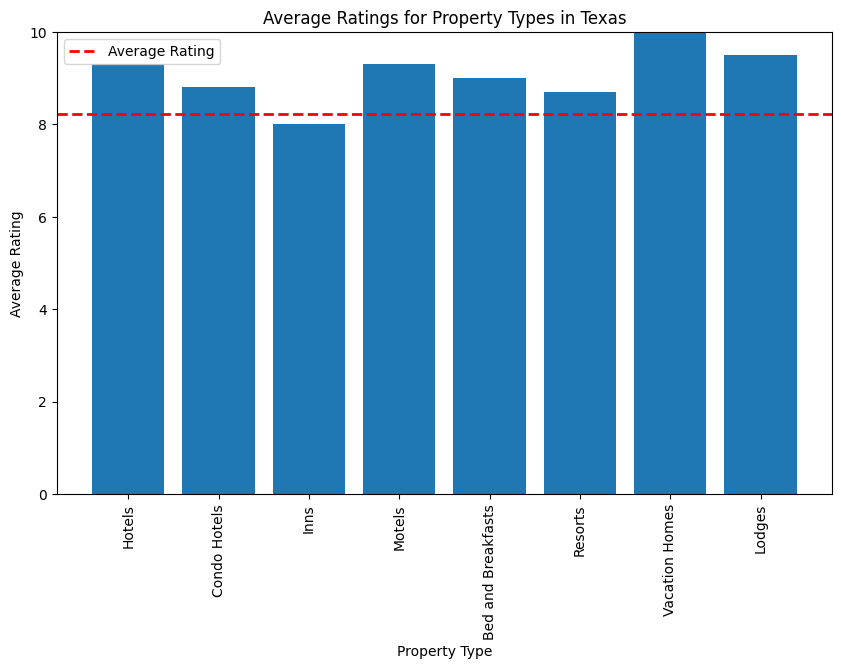

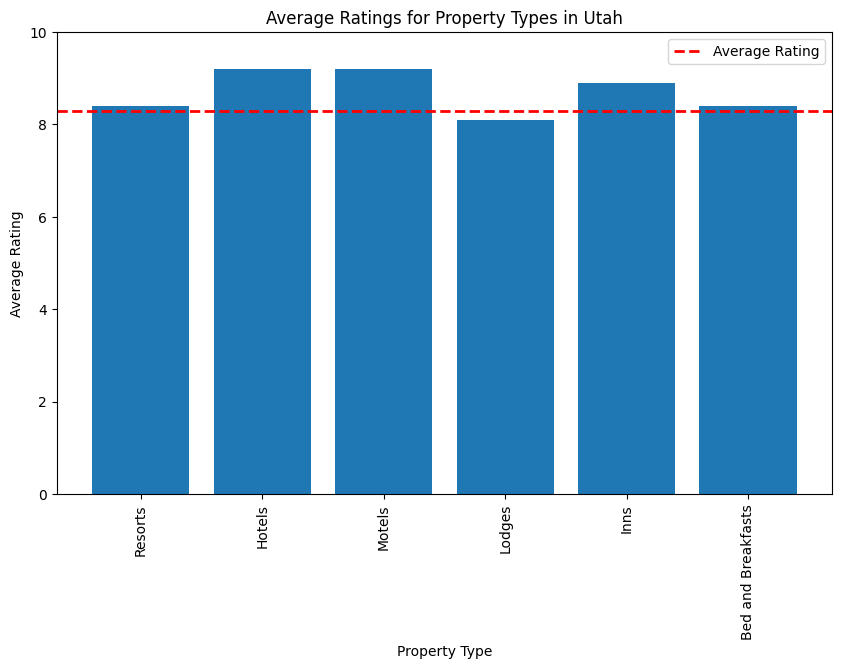

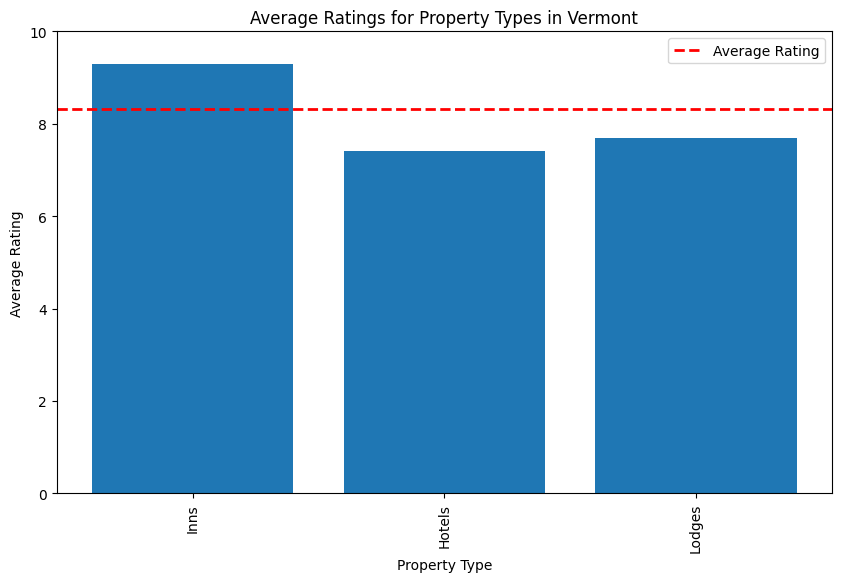

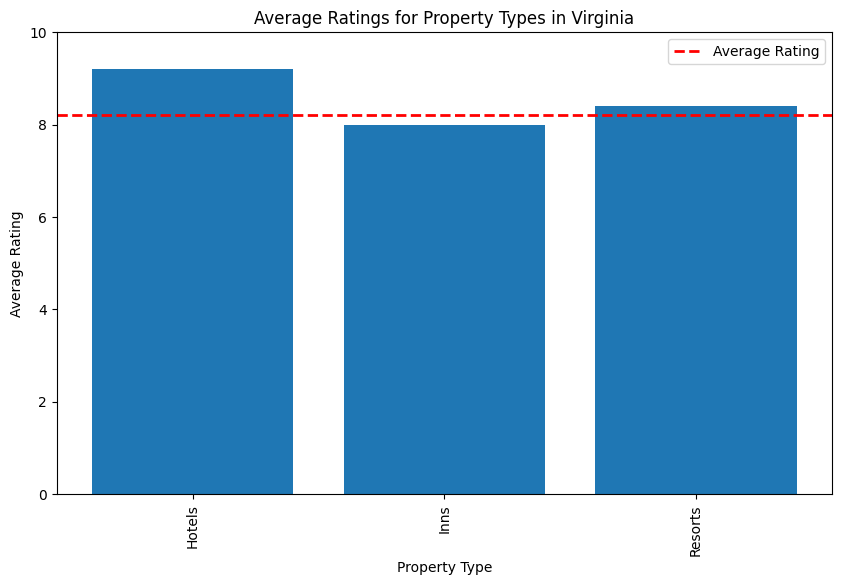

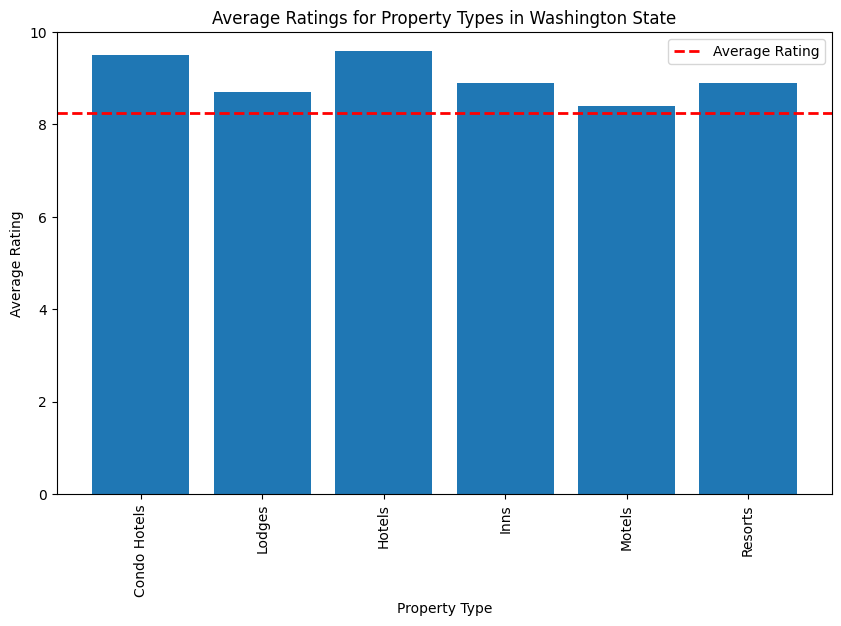

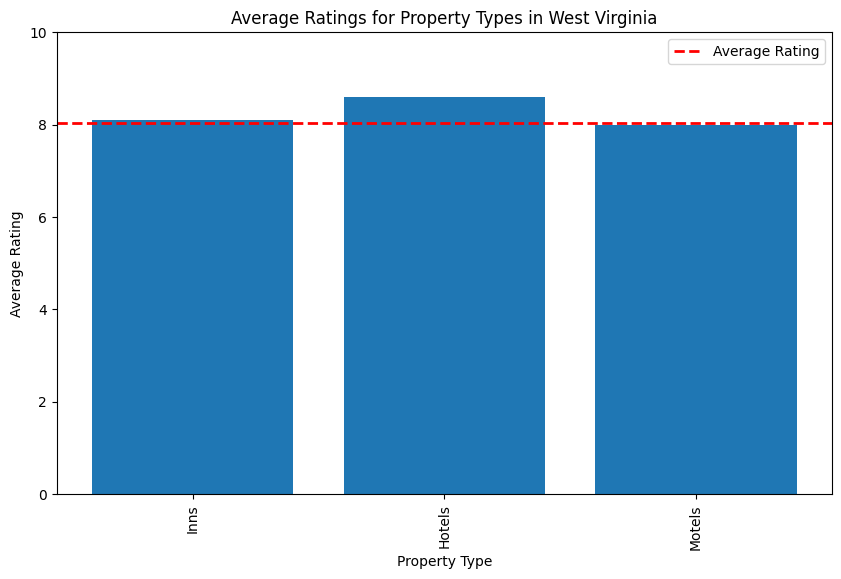

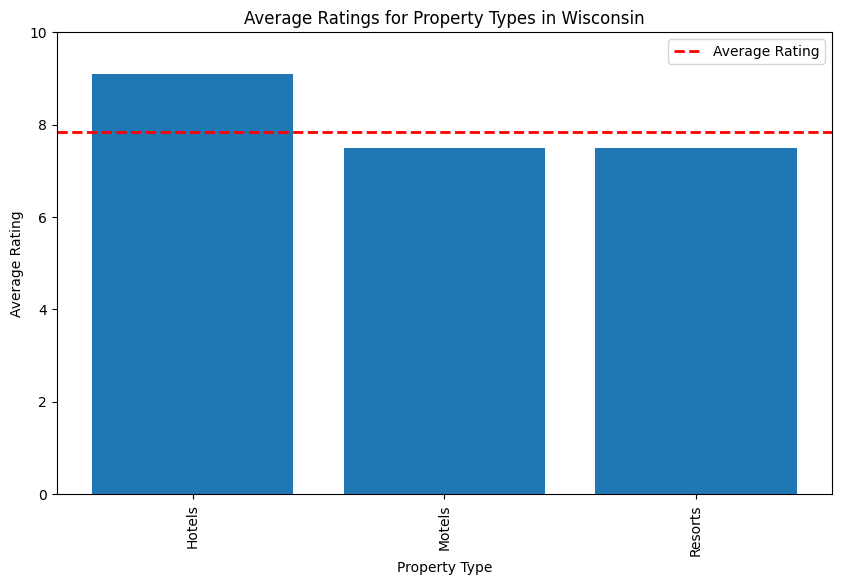

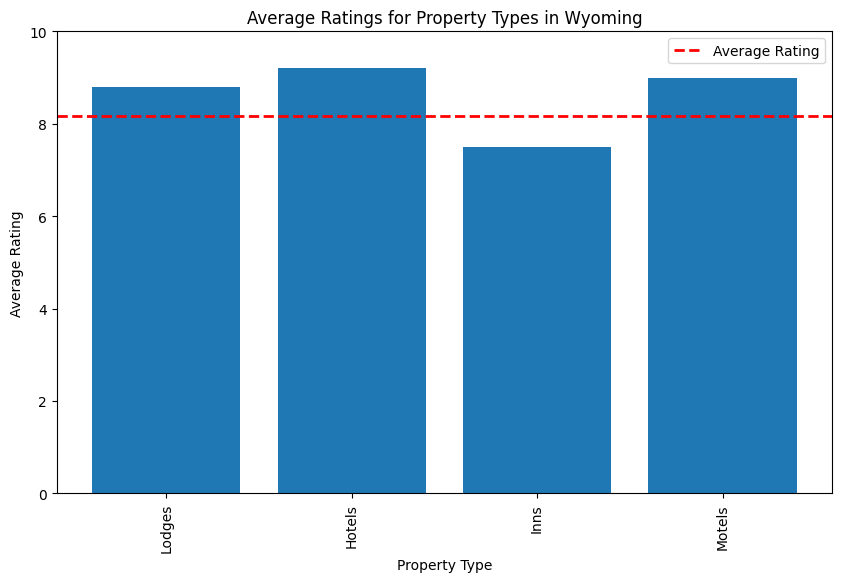

In [17]:
import matplotlib.pyplot as plt

region_avg_ratings = df.groupby('region_name')['rating'].mean().reset_index()

for _, row in region_avg_ratings.iterrows():
    region = row['region_name']  
    avg_rating = row['rating']  

    region_data = df[df['region_name'] == region]

    plt.figure(figsize=(10, 6))
    plt.bar(region_data['atnm'], region_data['rating'])
    plt.xlabel('Property Type')
    plt.ylabel('Average Rating')
    plt.title(f'Average Ratings for Property Types in {region}')
    plt.xticks(rotation=90)
    plt.ylim(0, 10)  
    plt.axhline(avg_rating, color='red', linestyle='--', linewidth=2, label='Average Rating')
    plt.legend()
    plt.show()

# Average Ratings by Property Type in Each Region

we analyze the average ratings for different property types within each region. The following steps are performed:

Calculating Average Ratings: We group the DataFrame by the 'region_name' column and calculate the mean of the 'rating' column using groupby('region_name')['rating'].mean(). The resulting data is stored in the region_avg_ratings DataFrame, which consists of two columns: 'region_name' and 'rating'.

Plotting Average Ratings: For each row in the region_avg_ratings DataFrame, we retrieve the region name and average rating. We then filter the DataFrame to include only the data for that specific region using df[df['region_name'] == region].

Creating a Bar Plot: We create a bar plot to display the average ratings for each property type within the selected region. The x-axis represents the property types ('atnm' column), and the y-axis represents the average rating. Additionally, we set the title of the plot to include the region name and customize the axis labels.

Visualizing Average Ratings: We set the y-axis limits to be between 0 and 10 to ensure consistent scaling. We add a horizontal dashed line at the average rating value using plt.axhline to provide a reference point for comparison. The line is colored red and labeled as 'Average Rating'. Finally, we display the legend, rotate the x-axis labels for better readability, and show the plot.

By plotting the average ratings for different property types in each region, we can gain insights into the performance of different property types within specific areas. The bar plots allow for easy comparison and identification of property types that have higher or lower average ratings within a particular region. The inclusion of the average rating reference line helps to gauge the performance of individual property types relative to the region's overall average rating.

# MACHINE LEARNING

# Using the Dataframe's numeric and categorical columns (Linear Regression)



we perform data preprocessing steps to prepare the dataset for machine learning using linear regression. The following steps are executed:

Defining the Columns: We select a subset of columns from the DataFrame that are relevant for our analysis. These columns include 'atnm', 'region_name', and several binary features such as 'outdoor_swimming_pool', 'restaurant', 'free_parking', 'fitness_center', 'breakfast', 'bar', 'indoor_swimming_pool', 'spa', and 'room_service'.

Separating the Features and Target: We assign the selected columns as the features to the variable X. The target variable 'rating_normalized' is assigned to the variable y.

One-Hot Encoding: We perform one-hot encoding on the categorical columns 'atnm' and 'region_name' using pd.get_dummies(). This process converts the categorical variables into binary dummy variables, allowing the machine learning algorithm to interpret them.

Splitting the Dataset: We split the encoded features (X_encoded) and the target variable (y) into training and testing sets using train_test_split(). The testing set size is set to 20% of the total dataset, and a random state of 42 is used for reproducibility.

Model Training: We initialize a linear regression model using LinearRegression() and fit it to the training data (X_train and y_train) using model.fit().

Predicting and Evaluating: We use the trained model to make predictions on the testing set (X_test) and store the predicted values in y_pred. We then calculate the mean squared error (MSE) between the predicted and actual target values using mean_squared_error(). The MSE is a measure of how well the model's predictions align with the true values.

Displaying the Results: We print the calculated MSE value using print("Mean Squared Error:", mse) to evaluate the performance of the linear regression model.

By performing these preprocessing steps and training a linear regression model, we aim to predict the normalized ratings based on the selected features. The mean squared error is used as an evaluation metric to assess the accuracy of the model's predictions.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

columns = ['atnm', 'region_name', 'outdoor_swimming_pool', 'restaurant', 'free_parking',
           'fitness_center', 'breakfast', 'bar', 'indoor_swimming_pool', 'spa', 'room_service']

X = df[columns]
y = df['rating_normalized']

X_encoded = pd.get_dummies(X, columns=['atnm', 'region_name'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)


Mean Squared Error: 9.866024842521367e+18


# 2. Logistic Regression

we define a criterion to identify successful and unsuccessful hotels based on their ratings. The following steps are performed:

Defining the Criterion: We define a criterion for categorizing hotels as successful or unsuccessful based on their ratings. Here, we consider hotels with a rating higher than 8 as successful and assign them a value of 1. On the other hand, hotels with a rating less than or equal to 8 are considered unsuccessful and assigned a value of 0.

Creating a New Column: We create a new column named 'is_successful' in the DataFrame (df) to store the categorization results.

Categorizing Hotels: We iterate over each rating in the 'rating' column of the DataFrame. For each rating, we compare it to the threshold value of 8. If the rating is greater than 8, we append 1 to the 'is_successful' list. Otherwise, we append 0.

Assigning the List to the DataFrame: We assign the 'is_successful' list to the 'is_successful' column in the DataFrame using df["is_successful"] = sucessful.

Counting Unsuccessful Hotels: We print the count of unsuccessful hotels by filtering the DataFrame to include only the rows where 'is_successful' is equal to 0 using df[df.is_successful == 0]. The length of this filtered DataFrame represents the number of unsuccessful hotels.

Counting Successful Hotels: We print the count of successful hotels by filtering the DataFrame to include only the rows where 'is_successful' is equal to 1 using df[df.is_successful == 1]. The length of this filtered DataFrame represents the number of successful hotels.

By categorizing hotels as successful or unsuccessful based on their ratings, we gain insights into the distribution and prevalence of successful and unsuccessful hotels in the dataset. The counts of unsuccessful and successful hotels are printed to provide an understanding of the overall distribution.

In [35]:
sucessful = []
for rating in df.rating:
    if rating > 8:
        sucessful.append(1)
    else : sucessful.append(0)
df["is_successful"] = sucessful
print("Amount of unsuccessful Hotels:")
print(len(df[df.is_successful == 0]))
print("Amount of successful Hotels:")
print(len(df[df.is_successful == 1]))

Amount of unsuccessful Hotels:
2551
Amount of successful Hotels:
3336


/tmp/ipykernel_119536/1706202933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_successful"] = sucessful


In [36]:
df

,name,rating,atnm,region_name,outdoor_swimming_pool,restaurant,free_parking,fitness_center,breakfast,bar,indoor_swimming_pool,spa,room_service,rating_normalized,is_successful
0,Desert Inn,7.6,Motels,New Mexico,0,0,0,1,1,0,1,1,0,0.349322,0
1,Super 8 by Wyndham Portales,6.9,Motels,New Mexico,0,0,1,0,1,0,0,0,0,0.165988,0
2,Ohkay Hotel Casino,7.9,Hotels,New Mexico,1,1,1,1,1,1,0,1,0,0.445397,0
3,Best Western Plus Portales Inn,8.6,Hotels,New Mexico,0,0,1,1,1,0,0,1,0,0.672089,1
4,"Holiday Inn Express & Suites Portales, an IHG ...",8.3,Hotels,New Mexico,0,0,0,1,1,0,0,1,0,0.577631,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,"Motel 6-Porterville, CA",6.3,Hotels,California,1,0,1,0,0,0,0,0,0,0.070802,0
5929,Wildflower Boutique Motel,9.4,Hotels,California,0,0,1,0,1,0,0,0,0,0.866923,1
5930,WorldMark Clear Lake,9.1,Hotels,California,0,0,1,0,0,0,0,0,0,0.805686,1
5931,Sonesta Select Pleasant Hill,8.0,Hotels,California,0,1,0,1,1,0,0,1,0,0.478461,0


# Splitting the Dataset for Machine Learning

we split the dataset into training and testing sets to prepare for machine learning tasks. The following steps are performed:

Defining the Target Variable: We assign the 'is_successful' column of the DataFrame (df) to the variable 'y'. This column contains the labels indicating whether a hotel is successful or not.

Creating the Feature Matrix: We create the feature matrix 'X' by making a copy of the DataFrame (df). We exclude certain columns from the feature matrix that are not required for our machine learning task. The excluded columns are 'name', 'rating', 'atnm', 'region_name', 'rating_normalized', and 'is_successful'.

Splitting the Dataset: We use the train_test_split function from the scikit-learn library to split the feature matrix ('X') and the target variable ('y') into training and testing sets. The training set is used to train our machine learning model, while the testing set is used to evaluate its performance. Here, we allocate 15% of the data to the testing set, and the remaining 85% is assigned to the training set. The random_state parameter ensures reproducibility of the split.

Assignment of Split Data: We assign the split data to the variables 'X_train', 'X_test', 'y_train', and 'y_test'. 'X_train' contains the feature matrix of the training set, 'X_test' contains the feature matrix of the testing set, 'y_train' contains the target variable of the training set, and 'y_test' contains the target variable of the testing set.

By splitting the dataset into training and testing sets, we can train our machine learning model on the training data and evaluate its performance on the testing data. This enables us to assess how well the model generalizes to unseen data and provides an estimate of its performance in real-world scenarios.

In [37]:
y = df["is_successful"]
X = df.copy()

X = X.loc[:, X.columns!='name']
X = X.loc[:, X.columns!='rating']
X = X.loc[:, X.columns!='atnm']
X = X.loc[:, X.columns!='region_name']
X = X.loc[:, X.columns!='rating_normalized']
X = X.loc[:, X.columns!='is_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 687)

In [38]:
X

,outdoor_swimming_pool,restaurant,free_parking,fitness_center,breakfast,bar,indoor_swimming_pool,spa,room_service
0,0,0,0,1,1,0,1,1,0
1,0,0,1,0,1,0,0,0,0
2,1,1,1,1,1,1,0,1,0
3,0,0,1,1,1,0,0,1,0
4,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
5928,1,0,1,0,0,0,0,0,0
5929,0,0,1,0,1,0,0,0,0
5930,0,0,1,0,0,0,0,0,0
5931,0,1,0,1,1,0,0,1,0


In [39]:
y

0       0
1       0
2       0
3       1
4       1
       ..
5928    0
5929    1
5930    1
5931    0
5932    1
Name: is_successful, Length: 5887, dtype: int64

# Training and Evaluating the Logistic Regression Model

we train a logistic regression model using the training data and evaluate its performance. The following steps are performed:

Model Initialization: We initialize a logistic regression model by creating an instance of the LogisticRegression class.

Model Training: We train the logistic regression model using the fit method. The training data, consisting of the feature matrix 'X_train' and the target variable 'y_train', is used to train the model.

Making Predictions: We use the trained model to make predictions on the training data by calling the predict method on the feature matrix 'X_train'. The predicted labels are assigned to the variable 'y_predicted'.

Evaluating Accuracy: We compare the predicted labels ('y_predicted') with the actual labels from the training data ('y_train.values') to evaluate the accuracy of the model. The accuracy score is calculated using the score method of the logistic regression model, which computes the mean accuracy on the given test data and labels.

Printing Accuracy Score: We print the accuracy score of the logistic regression model on the training data to assess its performance.

By training the logistic regression model on the training data and evaluating its accuracy, we can gain insights into how well the model is able to classify hotels as successful or unsuccessful based on the given features.

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_train)
y_predicted
y_train.values
print("Accuracy score for train")

model.score(X_train,y_train)

Accuracy score for train


0.6126324205476714

In [41]:
y_predicted = model.predict(X_test)
y_predicted


array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,

In [42]:
y_test.values

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,

In [43]:
print("Accuracy score for test")
model.score(X_test,y_test)

Accuracy score for test


0.6108597285067874

# CONCLUSIONS:

The aim of the research project was to examine whether it is possible to predict the hotel rating based on its parameters. We explored multiple approaches and applied various methods and models to achieve accurate prediction results. After analyzing the results and evaluating the performance of different techniques, we have reached the following conclusions:

Regression-based Methods: We initially explored regression-based methods, specifically extracting binary parameters from the Booking website. However, these methods did not yield satisfactory results in accurately predicting hotel ratings. The binary parameters alone were not sufficient to capture the complexity and nuances associated with hotel ratings.

Feature Selection: We performed feature selection by identifying relevant columns and removing irrelevant ones from the dataset. This process helped to improve the model's performance by focusing on the most informative features.

Machine Learning Models: We employed various machine learning models such as linear regression and logistic regression to predict hotel ratings and classify successful and unsuccessful hotels. While these models provided insights into the relationship between features and ratings, they did not achieve the desired level of accuracy for prediction.

Limitations: It is important to acknowledge the limitations of our approach. The dataset we used may have inherent biases and limitations, and the predictive power of our models could be affected by the quality and availability of the data. Additionally, other factors such as customer reviews quantity and external factors not captured in our dataset may play a significant role in determining hotel ratings.

Further Research: Our findings indicate that predicting hotel ratings based solely on the provided parameters is challenging. To improve the accuracy of predictions, further research could focus on incorporating additional data sources, such as customer reviews, social media sentiment analysis, or external factors like location and market conditions. Additionally, exploring advanced machine learning techniques, such as ensemble methods or neural networks, may offer potential improvements in prediction accuracy.

In conclusion, while our research project explored different methods and models for predicting hotel ratings based on parameters, we acknowledge that predicting ratings solely based on the provided dataset is a complex task. Further research and refinement of models, along with the inclusion of additional data sources, are necessary to develop more accurate prediction models in the hospitality industry.